# Libraries

In [ ]:
# 📁 Drive assembly
# From Google.colab Import Drive
# Drive.Mount ('/content/drive')

# ⚙️ Initial configuration
import os
import random
import re
import warnings
warnings.filterwarnings("ignore")

# 📆 Market calendars
import pandas_market_calendars as mcal

# 📊 Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

# 🧼 Cleaning and preprocessing data
import numpy as np
import pandas as pd

# 🔬 Statistical analysis
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

# 🧠 Modeling and Machine Learning
import keras_tuner as kt
import tensorflow as tf
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor

# 🤖 Deep Learning (keras / tensorflow)
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import AdamW


2025-07-22 15:13:22.973462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753215203.006520  125387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753215203.015987  125387 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753215203.042060  125387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753215203.042131  125387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753215203.042133  125387 computation_placer.cc:177] computation placer alr

# 1. Cleaning and preprocessing

DATASET is loaded

In [3]:
# Route to the folder with the CSVs on Google Drive
carpeta_csv = "Dataset"

Files are listed

In [4]:
archivos_csv = [f for f in os.listdir(carpeta_csv) if f.endswith('.csv')]
dataframes_filtrados = {}

We use a range of dates between 2010 - 2025

In [5]:
# Rank of dates that we want to keep
fecha_inicio = pd.to_datetime("2010-01-01")
fecha_fin = pd.to_datetime("2025-05-31")

# Special names with a different format of date
formatos_fecha_por_archivo = {
    "vix_history.csv": "%m/%d/%Y",
    "tasa_de_desempleo_usa.csv": "%Y-%m-%d"
}

File name function as indicator label

In [6]:
def extraer_nombre_indicador(nombre_archivo):
    nombre = nombre_archivo.lower().replace("datos_historicos_", "").replace(".csv", "")
    nombre = re.sub(r"[^a-z0-9]+", "_", nombre).strip("_")
    return nombre

Function to process the CSVS

In [7]:
def procesar_datasets():
    for archivo in archivos_csv:
        ruta = os.path.join(carpeta_csv, archivo)
        try:
            df = pd.read_csv(ruta)

            # Identify date column
            columna_fecha = next((col for col in df.columns if 'fecha' in col.lower() or 'date' in col.lower()), None)
            if columna_fecha is None:
                print(f"⚠️ No se encontró columna de fecha en {archivo}")
                continue

            # Parsear date with the specific format if applied
            formato_fecha = formatos_fecha_por_archivo.get(archivo.lower())
            if formato_fecha:
                df[columna_fecha] = pd.to_datetime(df[columna_fecha], format=formato_fecha, errors='coerce')
            else:
                df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce', dayfirst=True)

            df = df.rename(columns={columna_fecha: 'fecha'})

            # Filter daughter range
            df = df[(df['fecha'] >= fecha_inicio) & (df['fecha'] <= fecha_fin)]

            # Identify main value column
            columnas_valor = ['Último', 'CLOSE', 'Actual', 'tasa_desempleo_usa']
            columna_valor = next((col for col in df.columns if col in columnas_valor), None)
            if columna_valor is None:
                print(f"⚠️ No se encontró columna de valor principal en {archivo}")
                continue

            # Create clean name for the series
            nombre_serie = extraer_nombre_indicador(archivo)
            df = df[['fecha', columna_valor]].copy()
            df = df.rename(columns={columna_valor: nombre_serie})
            df = df.sort_values(by='fecha')

            dataframes_filtrados[nombre_serie] = df

            print(f"✅ Procesado: {archivo} -> columnas: fecha, {nombre_serie} (filtrado por fecha)")

        except Exception as e:
            print(f"❌ Error procesando {archivo}: {e}")

# Execute processing
procesar_datasets()

✅ Procesado: Datos_historicos_tasa_interes_FED.csv -> columnas: fecha, tasa_interes_fed (filtrado por fecha)
✅ Procesado: Datos_historicos_indice_euro.csv -> columnas: fecha, indice_euro (filtrado por fecha)
✅ Procesado: Datos_historicos_petroleo_Brent.csv -> columnas: fecha, petroleo_brent (filtrado por fecha)
✅ Procesado: Datos_historicos_petroleo_crudo_WTI.csv -> columnas: fecha, petroleo_crudo_wti (filtrado por fecha)
✅ Procesado: Datos_historicos_nasdaq.csv -> columnas: fecha, nasdaq (filtrado por fecha)
✅ Procesado: Datos_historicos_indice_dolar.csv -> columnas: fecha, indice_dolar (filtrado por fecha)
✅ Procesado: VIX_History.csv -> columnas: fecha, vix_history (filtrado por fecha)
✅ Procesado: Datos_historicos_dow_jones.csv -> columnas: fecha, dow_jones (filtrado por fecha)
✅ Procesado: Datos_historicos_EUR_USD.csv -> columnas: fecha, eur_usd (filtrado por fecha)
✅ Procesado: Datos_historicos_oro.csv -> columnas: fecha, oro (filtrado por fecha)
✅ Procesado: Datos_historicos_ren

Filters are generated to exclude weekends and holidays

In [8]:
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date='2010-01-01', end_date='2025-05-31')
trading_days = schedule.index

The data values are taken and expands to every day be able

In [9]:
def expandir_valores_mensuales(df, nombre_columna, trading_days):
    """
    df: DataFrame con columnas ['fecha', nombre_columna]
    nombre_columna: string, el nombre de la columna a extender
    trading_days: DatetimeIndex con fechas de trading

    Retorna un DataFrame con columna 'fecha' y el valor mensual expandido a todos los días hábiles del mes.
    """
    # Ensure what date is Datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Extract year and month for grouping
    df['año_mes'] = df['fecha'].dt.to_period('M')

    # Create dataframe with all trading_days and their respective year_mes
    df_trading = pd.DataFrame({'fecha': trading_days})
    df_trading['año_mes'] = df_trading['fecha'].dt.to_period('M')

    # Make Merge to assign monthly value to each business day
    df_expandido = df_trading.merge(df[['año_mes', nombre_columna]], on='año_mes', how='left')

    # Leave only date and value
    df_expandido = df_expandido[['fecha', nombre_columna]]

    print(f"✅ Expandido mensual: {nombre_columna} ({df.shape[0]} → {df_expandido.shape[0]} filas)")
    return df_expandido

Applies monthly expansion to these indicators

In [10]:
mensuales = ['tasa_interes_bce', 'tasa_interes_fed', 'tasa_de_desempleo_usa']

for indicador in mensuales:
    if indicador in dataframes_filtrados:
        df_original = dataframes_filtrados[indicador]
        df_expandido = expandir_valores_mensuales(df_original, indicador, trading_days)
        df_expandido[indicador] = df_expandido[indicador].ffill()
        dataframes_filtrados[indicador] = df_expandido

✅ Expandido mensual: tasa_interes_bce (143 → 3876 filas)
✅ Expandido mensual: tasa_interes_fed (124 → 3898 filas)
✅ Expandido mensual: tasa_de_desempleo_usa (185 → 3876 filas)


Columns are mixed

In [11]:
def merge_con_trading_days(dataframes_filtrados, trading_days):
    # Convert datetimeindex to dataframe with column 'date'
    df_merged = pd.DataFrame({'fecha': pd.to_datetime(trading_days)})

    # Iterate and make merge
    for nombre, df in dataframes_filtrados.items():
        if not isinstance(df, pd.DataFrame):
            print(f"⚠️ {nombre} no es un DataFrame. Se omite.")
            continue
        if 'fecha' not in df.columns:
            print(f"⚠️ {nombre} no contiene columna 'fecha'. Se omite.")
            continue

        df = df = dataframes_filtrados.get(nombre, pd.DataFrame()).copy()
        df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')  # just in case
        df_merged = df_merged.merge(df, on='fecha', how='left')
        print(f"🔗 Merge Ok: {nombre} ({df.shape[0]} filas)")

    return df_merged

df_completo = merge_con_trading_days(dataframes_filtrados, trading_days)

🔗 Merge Ok: tasa_interes_fed (3898 filas)
🔗 Merge Ok: indice_euro (4840 filas)
🔗 Merge Ok: petroleo_brent (3980 filas)
🔗 Merge Ok: petroleo_crudo_wti (4012 filas)
🔗 Merge Ok: nasdaq (3876 filas)
🔗 Merge Ok: indice_dolar (4013 filas)
🔗 Merge Ok: vix_history (3899 filas)
🔗 Merge Ok: dow_jones (4162 filas)
🔗 Merge Ok: eur_usd (4021 filas)
🔗 Merge Ok: oro (3929 filas)
🔗 Merge Ok: rendimiento_bonos_2_eeuu (4059 filas)
🔗 Merge Ok: tasa_de_desempleo_usa (3876 filas)
🔗 Merge Ok: tasa_interes_bce (3876 filas)
🔗 Merge Ok: s_p_500 (3876 filas)
🔗 Merge Ok: rendimiento_bonos_10_eeuu (4018 filas)


Result

In [12]:
print("\n✅ DataFrame final:")
print(df_completo.info())


✅ DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha                      3898 non-null   datetime64[ns]
 1   tasa_interes_fed           3898 non-null   object        
 2   indice_euro                3898 non-null   object        
 3   petroleo_brent             3898 non-null   object        
 4   petroleo_crudo_wti         3898 non-null   object        
 5   nasdaq                     3898 non-null   object        
 6   indice_dolar               3898 non-null   object        
 7   vix_history                3898 non-null   float64       
 8   dow_jones                  3898 non-null   object        
 9   eur_usd                    3898 non-null   object        
 10  oro                        3854 non-null   object        
 11  rendimiento_bonos_2_eeuu   3889 non-null   object

List of numerical columns with problems

In [13]:
cols_objeto = ['dow_jones', 'eur_usd', 'indice_dolar', 'indice_euro', 'nasdaq',
               'oro', 'petroleo_brent', 'petroleo_crudo_wti',
               'rendimiento_bonos_10_eeuu', 'rendimiento_bonos_2_eeuu',
               's_p_500', 'tasa_interes_bce', 'tasa_interes_fed']

for col in cols_objeto:
    df_completo[col] = df_completo[col].str.replace('.', '', regex=False)  # Eliminates thousands separator
    df_completo[col] = df_completo[col].str.replace(',', '.', regex=False)  # converts comimal to point
    df_completo[col] = pd.to_numeric(df_completo[col], errors='coerce')  # Convert to Float

Delete rows with nan

In [14]:
df_completo.dropna(inplace=True)
print("\n✅ DataFrame final sin NaN:")
print(df_completo.info())


✅ DataFrame final sin NaN:
<class 'pandas.core.frame.DataFrame'>
Index: 3844 entries, 0 to 3897
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha                      3844 non-null   datetime64[ns]
 1   tasa_interes_fed           3844 non-null   float64       
 2   indice_euro                3844 non-null   float64       
 3   petroleo_brent             3844 non-null   float64       
 4   petroleo_crudo_wti         3844 non-null   float64       
 5   nasdaq                     3844 non-null   float64       
 6   indice_dolar               3844 non-null   float64       
 7   vix_history                3844 non-null   float64       
 8   dow_jones                  3844 non-null   float64       
 9   eur_usd                    3844 non-null   float64       
 10  oro                        3844 non-null   float64       
 11  rendimiento_bonos_2_eeuu   3844 non-null   flo

In [15]:
df_completo.tail()

,fecha,tasa_interes_fed,indice_euro,petroleo_brent,petroleo_crudo_wti,nasdaq,indice_dolar,vix_history,dow_jones,eur_usd,oro,rendimiento_bonos_2_eeuu,tasa_de_desempleo_usa,tasa_interes_bce,s_p_500,rendimiento_bonos_10_eeuu
3893,2025-05-23,0.045,132.95,64.21,61.53,18737.21,99.11,22.29,41603.07,1.1365,3394.5,3.991,4.2,0.024,5802.82,4.507
3894,2025-05-27,0.045,133.17,63.57,60.89,19199.16,99.52,18.96,42343.65,1.1329,3313.7,3.975,4.2,0.024,5921.54,4.445
3895,2025-05-28,0.045,132.71,64.32,61.84,19100.94,99.88,19.31,42098.70,1.1293,3308.3,3.991,4.2,0.024,5888.55,4.474
3896,2025-05-29,0.045,132.74,64.15,60.94,19175.87,99.28,19.18,42215.73,1.1372,3343.9,3.938,4.2,0.024,5912.17,4.425
3897,2025-05-30,0.045,132.61,63.90,60.79,19113.77,99.33,18.57,42270.07,1.1348,3315.4,3.898,4.2,0.024,5911.69,4.397


Functions to calculate RSI, simple mobile socks (SMA) and exponential mobile socks (EMA)

In [16]:
def calculate_rsi(data, column='close', period=14):
    """
    Calcula el Relative Strength Index (RSI) de una serie temporal.

    :param data: DataFrame con los datos históricos.
    :param column: Nombre de la columna sobre la que calcular el RSI (por defecto 'close').
    :param period: Periodo de cálculo del RSI (por defecto 14).
    :return: Columna del DataFrame con el RSI calculado.
    """
    delta = data[column].diff()  # Differences between consecutive prices
    gain = delta.where(delta > 0, 0)  # Profits (when Delta is positive)
    loss = -delta.where(delta < 0, 0)  # Losses (when Delta is negative)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()  # Mobile Profit Media
    avg_loss = loss.rolling(window=period, min_periods=1).mean()  # Mobile losses average

    rs = avg_gain / avg_loss  # Relative force ratio
    rsi = 100 - (100 / (1 + rs))  # RSI formula

    return rsi


def calculate_sma(data, column='close', period=14):
    """
    Calcula la Media Móvil Simple (SMA) de una serie temporal.

    :param data: DataFrame con los datos históricos.
    :param column: Nombre de la columna sobre la que calcular el SMA (por defecto 'close').
    :param period: Periodo de cálculo de la SMA (por defecto 14).
    :return: Columna del DataFrame con el SMA calculado.
    """
    sma = data[column].rolling(window=period, min_periods=1).mean()
    return sma


def calculate_ema(data, column='close', period=14):
    """
    Calcula la Media Móvil Exponencial (EMA) de una serie temporal.

    :param data: DataFrame con los datos históricos.
    :param column: Nombre de la columna sobre la que calcular el EMA (por defecto 'close').
    :param period: Periodo de cálculo del EMA (por defecto 14).
    :return: Columna del DataFrame con el EMA calculado.
    """
    ema = data[column].ewm(span=period, adjust=False).mean()
    return ema

Function to calculate the momentum

In [17]:
def calculate_momentum(data, column='close', period=10):
    """
    Calcula el Momentum de una serie temporal.

    :param data: DataFrame con los datos históricos.
    :param column: Nombre de la columna sobre la que calcular el Momentum (por defecto 'close').
    :param period: Periodo de cálculo del Momentum (por defecto 10).
    :return: Serie con el Momentum calculado.
    """
    momentum = data[column] - data[column].shift(period)
    return momentum

def calculate_macd(data, column='close', fast_period=12, slow_period=26, signal_period=9):
    """
    Calcula el MACD (Moving Average Convergence Divergence) de una serie temporal.

    :param data: DataFrame con los datos históricos.
    :param column: Nombre de la columna sobre la que calcular el MACD (por defecto 'close').
    :param fast_period: Periodo de la EMA rápida (por defecto 12).
    :param slow_period: Periodo de la EMA lenta (por defecto 26).
    :param signal_period: Periodo de la línea de señal (por defecto 9).
    :return: DataFrame con las columnas 'macd', 'signal' y 'histogram'.
    """
    ema_fast = data[column].ewm(span=fast_period, adjust=False).mean()
    ema_slow = data[column].ewm(span=slow_period, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal

    return pd.DataFrame({
        'macd': macd,
        'signal': signal,
        'histogram': histogram
    })


14 -period calculations

In [18]:
# RSI calculate with 14 period
df_completo['RSI'] = calculate_rsi(df_completo, column='eur_usd', period=14)

# Calculate SMA with 14 period
df_completo['SMA'] = calculate_sma(df_completo, column='eur_usd', period=14)

# Calculate Ema with a period of 14
df_completo['EMA'] = calculate_ema(df_completo, column='eur_usd', period=14)

We process the data and show the data of the dataframe

In [19]:
df_completo['momentum'] = calculate_momentum(df_completo, column='eur_usd', period=10)
macd_df_completo = calculate_macd(df_completo, column='eur_usd')
df_completo = pd.concat([df_completo, macd_df_completo], axis=1)
df_completo.dropna(inplace=True)  # Delete rows with nan
df_completo.info()  # Show data from the Final Dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 3834 entries, 11 to 3897
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   fecha                      3834 non-null   datetime64[ns]
 1   tasa_interes_fed           3834 non-null   float64       
 2   indice_euro                3834 non-null   float64       
 3   petroleo_brent             3834 non-null   float64       
 4   petroleo_crudo_wti         3834 non-null   float64       
 5   nasdaq                     3834 non-null   float64       
 6   indice_dolar               3834 non-null   float64       
 7   vix_history                3834 non-null   float64       
 8   dow_jones                  3834 non-null   float64       
 9   eur_usd                    3834 non-null   float64       
 10  oro                        3834 non-null   float64       
 11  rendimiento_bonos_2_eeuu   3834 non-null   float64       
 12  tasa_de_de

We store the data

In [20]:
# Route where the Excel file will be saved
ruta_salida = os.path.join(carpeta_csv, 'df_completo_local.xlsx')

# Save the DataFrame in Excel
df_completo.to_excel(ruta_salida, index=False)

print(f"✅ Archivo guardado exitosamente en: {ruta_salida}")

✅ Archivo guardado exitosamente en: Dataset/df_completo_local.xlsx


# 2. Eda

Eda.ipynb

Automatically Generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Paa8lqeivejcubgsugsugfmqsdii4Oim

# Exploratory Data Analysis - EUR/USD Prediction

**Introduction**  
In this analysis we will work with a historical series of the EUR/USD exchange rate, which contains daily contributions from January 2010 to May of this year (2025). Our main objective is to explore in depth the behavior of this series, identify seasonal patterns and trends, and prepare a set of variables (features) that allow to subsequently build a predictive model capable of anticipating future movements in the Euro -Dó Challar relationship.  

---

## Section scheme

1. ** Initial load and validation **  
   - DATASET Reading  
   - Structure verification, missing data and values types  

2. ** Cleaning and preprocessing **  
   - Treatment of null or atypical values  
   - Conversion of dates and generation of time variables (day, month, year, week day)  

3. ** Descriptive analysis **  
   - Summarized statistics (medium, medium, standard deviation)  
   - Distribution of opening, closing, maximum and minimum prices  

4. ** Exploratory visualizations **  
   - Quotation time series  
   - Histograms and boxplots per year and per month  
   - Autocorrelation graphs (ACF/PACF)  

5. ** Decomposition of the series **  
   - Trend, seasonality and residual component  
   - Cycles and seasonality analysis  

6. ** Characteristics Engineering (Feature Engineering) **  
   - Daily yields and log -Rentabilities  
   - Mobile windows (Rolling Mean, Rolling Std)  
   - Technical indicators (RSI, mobile socks)  

7. ** Modeling preparation **  
   - Training/Test Division  
   - Variable scaling  
   - Definition of features and target sets  

8. ** Predictive modeling (Sketch) **  
   - Reference models: Arima, linear regression  
   - First approach with Machine Learning models (Random Forest, XGBOOST)  

9. ** EVALUATION AND VALIDATION **  
   - Error metrics (MAE, RMSE, MAPE)  
   - Backtesting on test set  

10. ** Conclusions and following steps **  
    - Main findings of EDA  
    - Recommendations for modeling and deployment

# Exploratory Data Analysis - EUR/USD Prediction

Forma del dataset: (3834, 23)
Periodo analizado: 0 a 3833
Número de días: 3834
Primeras 5 Filas
       fecha     oro  indice_dolar  petroleo_crudo_wti  petroleo_brent  vix_history  tasa_interes_bce  indice_euro  dow_jones  tasa_interes_fed  rendimiento_bonos_10_eeuu  rendimiento_bonos_2_eeuu   nasdaq  tasa_de_desempleo_usa  s_p_500  eur_usd        RSI       SMA       EMA  momentum      macd    signal  histogram
0 2010-01-20  1112.6         78.34               77.62           76.32        18.68              0.01       103.84   10603.15             0.003                      3.653                     0.882  2291.25                    9.8   1138.0   1.4101  31.097561  1.440209  1.439088   -0.0310 -0.001547  0.000286  -0.001832
1 2010-01-21  1103.2         78.32               76.08           74.58        22.27              0.01       103.74   10389.88             0.003                      3.595                     0.833  2265.70                    9.8   1116.5   1.4090  30.685921  1.43760

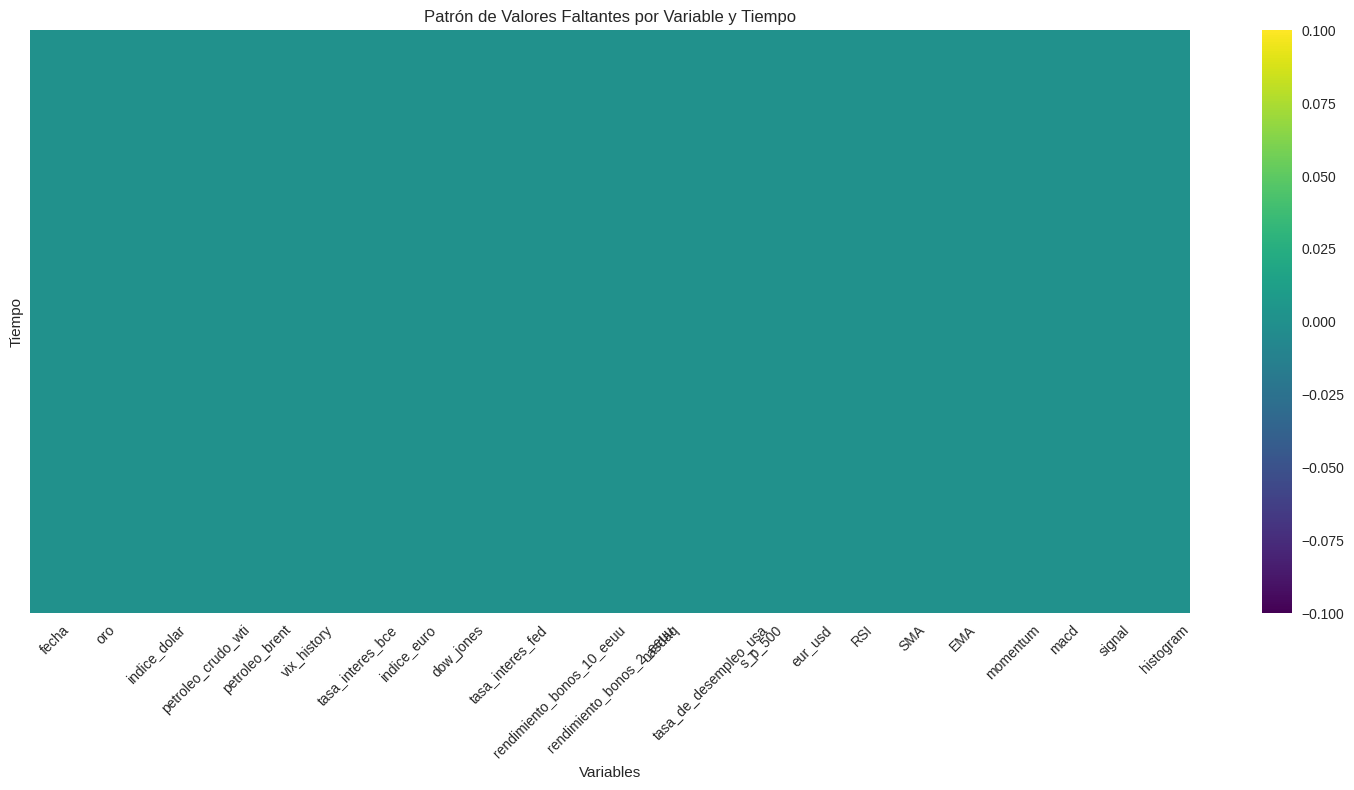

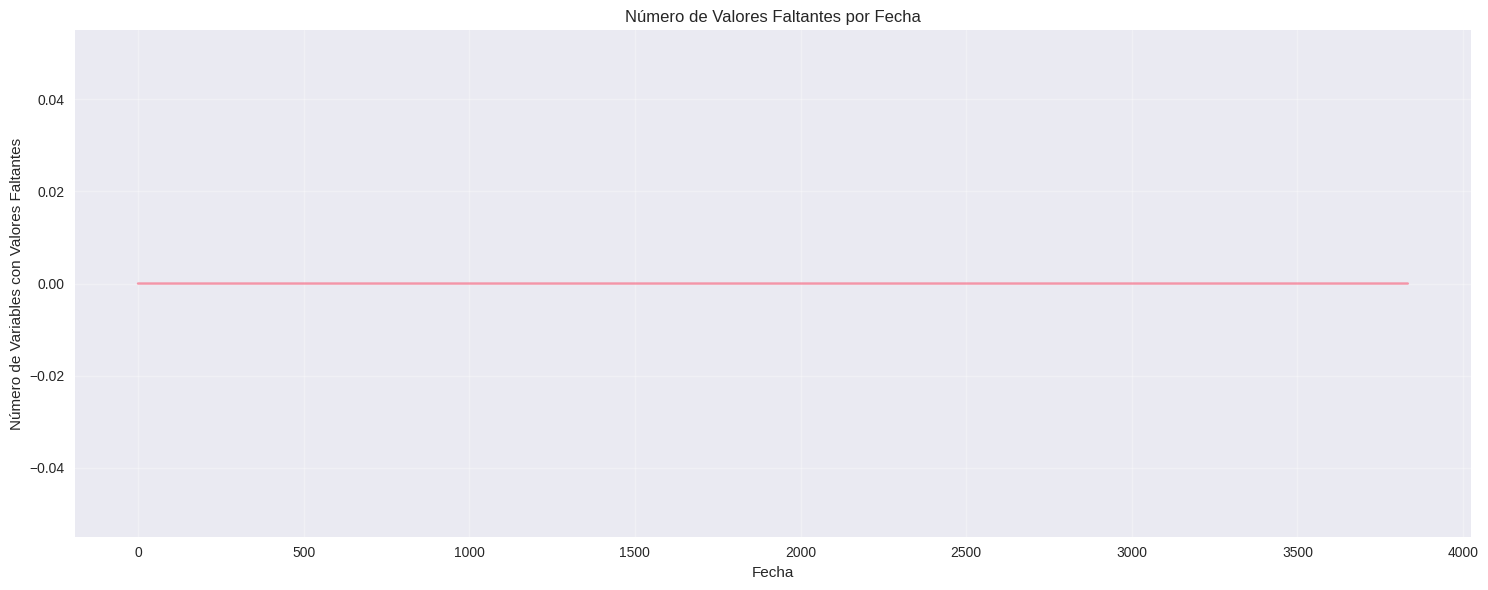

In [21]:

# Import of bookstores
# Data handling libraries
# # IMPORT PANDAS AS PD
# # Import Numpy as NP
# # Import Warnings
# # Warnings.filterwarNings ('Ignore')
# None
# # # Libraries for visualization
# # Import Matpletlib.pyploot as PLT
# # Import Seaborn as SNS
# # IMPORT PLOTLY.Graph_Objects as Go
# # Import Plotly.express as px
# # from plotly.sublots import make_subploots
# None
# # # Libraries for Statistical Analysis
# # From Scipy Import Stats
# # from scipy.stats import jarque_bera, shapiro, normotes
# # from statsmodels.tsa.stattools import adfuller, kps
# # from statsmodels.tsa.seasonal import seasonal_decompos
# # from statsmodels.stats.diagnostic import acor_ljungx

# Visualization configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

"""# # Initial load and validation of Dataset "" "

ruta = 'Dataset/df_completo.xlsx'
df = pd.read_excel(ruta)

print(f"Forma del dataset: {df.shape}")
print(f"Periodo analizado: {df.index.min()} a {df.index.max()}")
print(f"Número de días: {len(df)}")

# Basic inspection
print("Primeras 5 Filas")
print(df.head())
print("\nInformación General")
print(df.info())
print("\nEstadísticas Descriptivas")
print(df.describe())

"""# # Missing values analysis "" "

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Variable': missing_data.index,
    'Valores_Faltantes': missing_data.values,
    'Porcentaje': missing_percent.values
}).sort_values('Valores_Faltantes', ascending=False)

print("Análisis De Valores Faltantes")
print(missing_df[missing_df['Valores_Faltantes'] > 0])

# Viewing patterns of missing values
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Patrón de Valores Faltantes por Variable y Tiempo')
plt.xlabel('Variables')
plt.ylabel('Tiempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Temporary analysis of missing values to identify problematic periods
plt.figure(figsize=(15, 6))
missing_by_date = df.isnull().sum(axis=1)
plt.plot(df.index, missing_by_date, alpha=0.7)
plt.title('Número de Valores Faltantes por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Variables con Valores Faltantes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis of the target variable (EUR/USD)

The detailed analysis of the objective variable is fundamental because:

### Price behavior:
- ** Long -term trends **: Identify economic cycles and structural changes
- ** Support/resistance levels **: Historical ranges of trading
- ** Historical volatility **: High and low uncertainty periods

### Characteristics of returns:
- ** Distribution **: Evaluate Normality vs. Thick queues (Fat Tails)
- ** Volatility clustering **: High volatility periods followed by high volatility
- ** Asymmetry **: Trend towards positive or negative movements

This analysis informs about:
- ** appropriate prediction horizon **
- ** necessary transformations ** (Vs. returns)
-*Most relevant evaluation metric
- ** Risk Management Strategies **
""

Análisis De La Variable Objetivo
Estadísticas de eur_usd:
count    3834.000000
mean        1.185190
std         0.113069
min         0.959200
25%         1.095500
50%         1.142600
75%         1.287325
max         1.482600
Name: eur_usd, dtype: float64


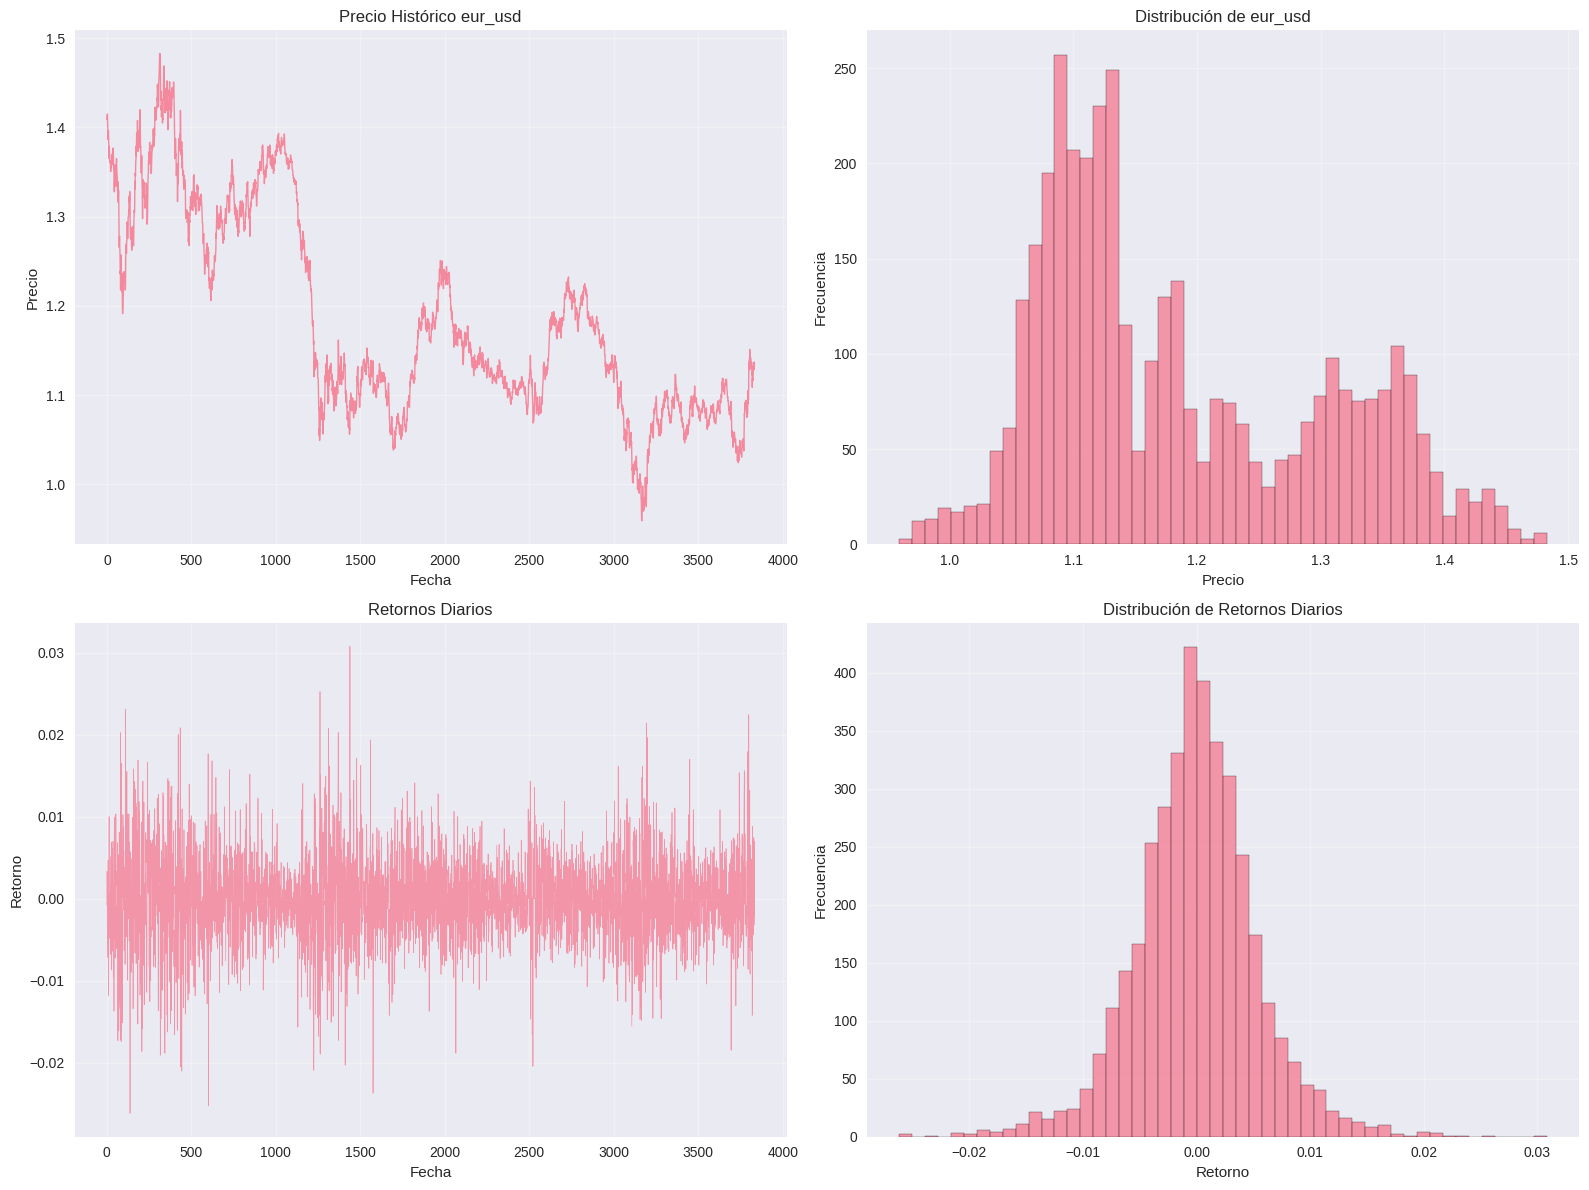

Estadísticas De Retornos
Retorno promedio diario: -0.000042
Volatilidad diaria: 0.005393
Volatilidad anualizada: 0.085614
Skewness: 0.0100
Kurtosis: 1.9131


In [22]:



# ANALYSIS OF THE OBJECTIVE VARIABLE
# This analysis helps us understand the historical behavior of the Eur/USD
# and identify patterns, trends and anomalies

target_col = 'eur_usd'  # Change by the real name of the column

print("Análisis De La Variable Objetivo")
print(f"Estadísticas de {target_col}:")
print(df[target_col].describe())

# Objective variable visualization
# Historical price chart and return analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Historical price
axes[0,0].plot(df.index, df[target_col], linewidth=1, alpha=0.8)
axes[0,0].set_title(f'Precio Histórico {target_col}')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Precio')
axes[0,0].grid(True, alpha=0.3)

# Price distribution
axes[0,1].hist(df[target_col].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title(f'Distribución de {target_col}')
axes[0,1].set_xlabel('Precio')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

# Daily returns
returns = df[target_col].pct_change().dropna()
axes[1,0].plot(returns.index, returns, linewidth=0.5, alpha=0.7)
axes[1,0].set_title('Retornos Diarios')
axes[1,0].set_xlabel('Fecha')
axes[1,0].set_ylabel('Retorno')
axes[1,0].grid(True, alpha=0.3)

# Returns distribution
axes[1,1].hist(returns, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribución de Retornos Diarios')
axes[1,1].set_xlabel('Retorno')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Returns statistics
print("Estadísticas De Retornos")
print(f"Retorno promedio diario: {returns.mean():.6f}")
print(f"Volatilidad diaria: {returns.std():.6f}")
print(f"Volatilidad anualizada: {returns.std() * np.sqrt(252):.6f}")
print(f"Skewness: {returns.skew():.4f}")
print(f"Kurtosis: {returns.kurtosis():.4f}")

## Parking analysis

Parking is a critical concept in temporary series because:

### Technical definition:
A series is ** stationary ** when its statistical properties (mean, variance, autocorrelation) do not change over time.

### Importance for modeling:
- ** Models Arima ** require stationary series
- ** Spurious regressions **: false relationships between non -stationary series
- ** Reliable prediction **: only possible with stationary series

### Tests implemented:
- ** ADF (augmented Dickey-Fuller) **: H0 = series has a unit root (non-stationary)
- ** KPSS **: H0 = series is stationary (complementary to ADF)

### Practical interpretation:
- ** Currency prices ** They are generally not stationary (Random Walk)
- ** Currency returns ** They are generally stationary
- ** First differences ** can induce parking

This analysis determines whether to work with levels, returns, or differences.

In [23]:
# Parking test function
def test_stationarity(timeseries, title):
    """
    Función para realizar tests de estacionaridad
    Combina ADF y KPSS para evaluación robusta
    """
    print(f"Tests De Estacionaridad Para {title}")

    # Dickey-Fuller test
    adf_result = adfuller(timeseries.dropna())
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")

    if adf_result[1] <= 0.05:
        print("✓ La serie es estacionaria según ADF (rechazamos H0)")
    else:
        print("✗ La serie NO es estacionaria según ADF (no rechazamos H0)")

    # KPSS test
    kpss_result = kpss(timeseries.dropna())
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Valores críticos:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.3f}")

    if kpss_result[1] >= 0.05:
        print("✓ La serie es estacionaria según KPSS (no rechazamos H0)")
    else:
        print("✗ La serie NO es estacionaria según KPSS (rechazamos H0)")
    print("\n" + "="*50 + "\n")

# Parking tests
# Test for the objective variable (levels)
test_stationarity(df[target_col], target_col)

# Test for returns
test_stationarity(returns, 'Retornos de EUR/USD')

# Test for the first differences
first_diff = df[target_col].diff().dropna()
test_stationarity(first_diff, 'Primera Diferencia de EUR/USD')

Tests De Estacionaridad Para eur_usd
ADF Statistic: -2.304135
p-value: 0.170638
Valores críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✗ La serie NO es estacionaria según ADF (no rechazamos H0)
KPSS Statistic: 6.225826
p-value: 0.010000
Valores críticos:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✗ La serie NO es estacionaria según KPSS (rechazamos H0)


Tests De Estacionaridad Para Retornos de EUR/USD
ADF Statistic: -36.854379
p-value: 0.000000
Valores críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✓ La serie es estacionaria según ADF (rechazamos H0)
KPSS Statistic: 0.071409
p-value: 0.100000
Valores críticos:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✓ La serie es estacionaria según KPSS (no rechazamos H0)


Tests De Estacionaridad Para Primera Diferencia de EUR/USD


/tmp/ipykernel_125387/1849089980.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna())
/tmp/ipykernel_125387/1849089980.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


ADF Statistic: -36.818326
p-value: 0.000000
Valores críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✓ La serie es estacionaria según ADF (rechazamos H0)
KPSS Statistic: 0.081359
p-value: 0.100000
Valores críticos:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
✓ La serie es estacionaria según KPSS (no rechazamos H0)




/tmp/ipykernel_125387/1849089980.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


"" "## Decomposition of temporary series

Decomposition separates a temporary series into fundamental components:

### Components:
1. ** Trend **: Long -term movement (bullish, bassist, side)
2. ** seasonality **: regular patterns that are repeated (annual, quarterly)
3. ** Waste **: Random component after removing trend and seasonality

### Applications in EUR/USD:
- ** Identify economic cycles **: Expansion/recession in US
- ** Detect seasonal patterns **: "Sell in May", end of the end of the year
- ** Evaluate random component **: How predicible is the series

### Modeling implications:
- ** strong trends **: models with drift component
- ** marked seasonality **: Include seasonal Dummy variables
- ** Waste with structure **: need for more complex models

This analysis informs about the predicible nature vs. random of the series.
""

Descomposición De La Serie Temporal


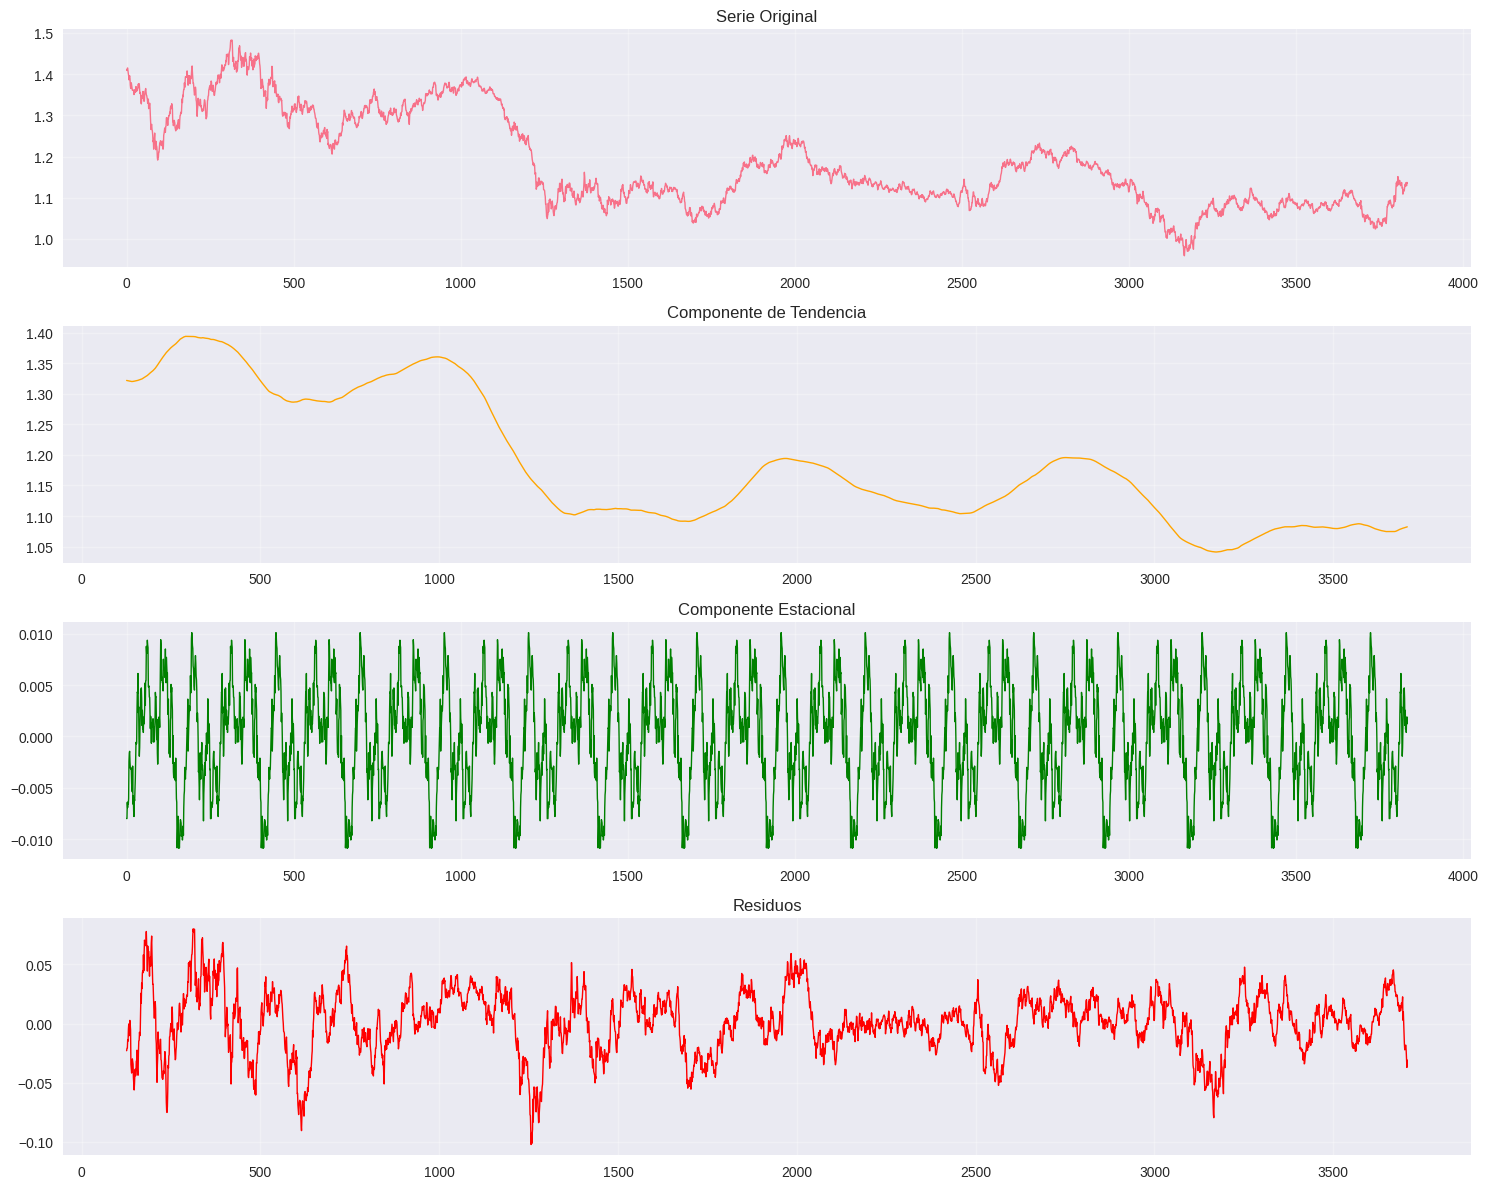

In [24]:
# Temporary decomposition
# Decomposition of the temporary series in trend, seasonality and waste
# This helps us understand the underlying components of the series
print("Descomposición De La Serie Temporal")

# Additive decomposition (assumes that the components are added)
# 252 days period corresponds approximately to one stock market
decomposition = seasonal_decompose(df[target_col].dropna(), model='additive', period=252)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original series
axes[0].plot(decomposition.observed, linewidth=1)
axes[0].set_title('Serie Original')
axes[0].grid(True, alpha=0.3)

# Trend - shows long -term address
axes[1].plot(decomposition.trend, linewidth=1, color='orange')
axes[1].set_title('Componente de Tendencia')
axes[1].grid(True, alpha=0.3)

# Seasonality - patterns that are repeated annually
axes[2].plot(decomposition.seasonal, linewidth=1, color='green')
axes[2].set_title('Componente Estacional')
axes[2].grid(True, alpha=0.3)

# Waste - What remains after removing trend and seasonality
axes[3].plot(decomposition.resid, linewidth=1, color='red')
axes[3].set_title('Residuos')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

"" "## Interpretation of the decomposition of the EUR/USD series

By applying additive decomposition with an annual period of 252 business days, we obtain four graphics that help us understand the dynamics of the exchange rate:

1. ** Observed Series **  
   The upper graph shows the daily price of the EUR/USD between the beginning of the sample and the most recent value. It is observed that the Euro -Dollar ratio begins about 1.40, reaches peaks around 1.45 - 1.47, and then has a prolonged decrease to approximately 1.05. Towards the end of the period, the price is recovering slightly, located by about 1.12 --1.15.

2. ** Trend component **  
   Long -term softization reveals two clear phases:  
   - ** Initial bullish ** (until about 300): The trend line rises from ~ 1.32 to ~ 1.40.  
   - ** Prolonged descent ** (from day 300 to around 1200): The trend turns at bassist, reaching minimums close to 1.08.  
   - ** Moderate stabilization ** (1200 onwards): After touching minimums, the trend recover slightly ground, oscillating between 1.05 and 1.10.

   This evolution confirms the presence of multi -year cycles: a first boom in the euro, followed by a marked fall and a consolidation period.

3. ** Seasonal component **  
   The seasonal series exhibits a pattern that is repeated every year, with typical amplitudes between +0.007 and −0.008. There are repetitions of peaks and valleys in regular intervals (~ 252 points), which suggests that there are moments of the year in which the euro tends to be appreciated or depreciated. This behavior could correspond to:
   - End of trimester or closure of fiscal year.  
   - Movements linked to monetary policy decisions in certain months.

4. ** Waste **  
   The waste chart, which collects the random part after removing trend and seasonality, shows a cloud centered to zero with relatively constant volatility. Picos of ± 0.05 or even ± 0.10 appear sometimes isolated, reflection of specific shocks (extreme data, unexpected news, market volatility).  
   - The amplitude of the waste is small compared to the original series, indicating that most of the variation is explained by trend and seasonality.  
   - For modeling, this waste should behave as "white noise": if they present self -correlation, it would be convenient to include self -repressive or mobile medium terms.

---

** Partial conclusion **  
- The ** tendency ** shows a regime change: an initial upward period, followed by a prolonged fall and subsequent stabilization.  
- The ** seasonality ** points to recurring annual effects that can be used as explanatory variables in a predictive model.  
- The ** waste ** suggest that, once extracted tendency and seasonality, the remaining series is relatively noise, but with certain peaks that could point to high volatility events.  

In the next step, we will prepare the transformations (log -backgrounds or first differences) and extract the characteristics (Rolling Windows and technical indicators) to train our Machine Learning models about an already stationary series.  

""

In [25]:
# Detailed analysis of decomposition residues
residuals = decomposition.resid.dropna()
print("Estadísticas De Los Residuos De Descomposición")
print(f"Media: {residuals.mean():.6f}")
print(f"Desviación estándar: {residuals.std():.6f}")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")

Estadísticas De Los Residuos De Descomposición
Media: 0.000762
Desviación estándar: 0.025647
Skewness: -0.3750
Kurtosis: 0.5853


## Interpretation of waste statistics

After calculating the additive decomposition and extracting the waste series, we get these metrics:

| Statistical | Value | Brief comment |
| ----------------------- | ----------- | -----------------------------------------------
| ** Media ** | 0.000762 | Very close to zero ⇒ Waste do not present systematic bias. |
| ** Standard deviation ** | 0.025647 | Reduced residual volatility compared to the original series. |
| ** Skewness ** | –0.3750 | Slightly biased to the left ⇒ negative tail a little more pronounced. |
| ** Kurtosis ** | 0.5853 | Excess positive curtosis (fisher) ⇒ queues heavier than a normal one. |

---

### What do these numbers tell us?

1. ** Media ≈ 0 **  
   - Indicates that, once the trend and seasonality have extracted, the waste symmetrically range around zero.  
   - Good indication that decomposition does not leave systematic "drift" in errors.

2. ** Low volatility (σ ≈ 0.026) **  
   - Most of the original series variation is already explained by trend and seasonality.  
   - The waste represents reasonably contained short -term fluctuations.

3. ** Light bias (Skew ≈ –0.38) **  
   - Something longer left queue ⇒ Sudden movements of euro appreciation (negative waste) were a bit more frequent or pronounced than depreciation.  
   - It is not an extreme bias, but it deserves attention if we want to model asymmetry.

4. ** Moderate curtosis (excess ≈ 0.59) **  
   - "heavier" tails than a normal distribution (excess> 0).  
   - It points to extreme events (shocks) more frequently than in a perfectly Gaussian noise.

## Correlation analysis

Correlation analysis reveals linear relationships between variables:

### Main objectives:
- ** Identify predictive variables **: greater correlation = greater potential predictive power
- ** Detect multicolinerality **: highly correlated variables
- ** Select features **: prioritize variables with high correlation with target and low among them

### Interpretation of correlations:
- ** | r | > 0.7 **: Strong correlation - Main candidate for model
- ** | r | 0.3-0.7 **: Moderate correlation - Evaluate together with other variables
- ** | r | <0.3 **: Weak correlation - It can be useful in ensemble

### Special considerations:
- ** correlation does not imply causality **
- ** Non -linear relationships ** They are not captured
- ** Temporary correlations ** may be more relevant than snapshots

### Multicolinerality:
Highly correlated variables (> 0.8) can cause:
- ** Instability in coefficients **
- ** Reduction in interpretability **
- ** Overfitting problems **

Análisis De Correlaciones


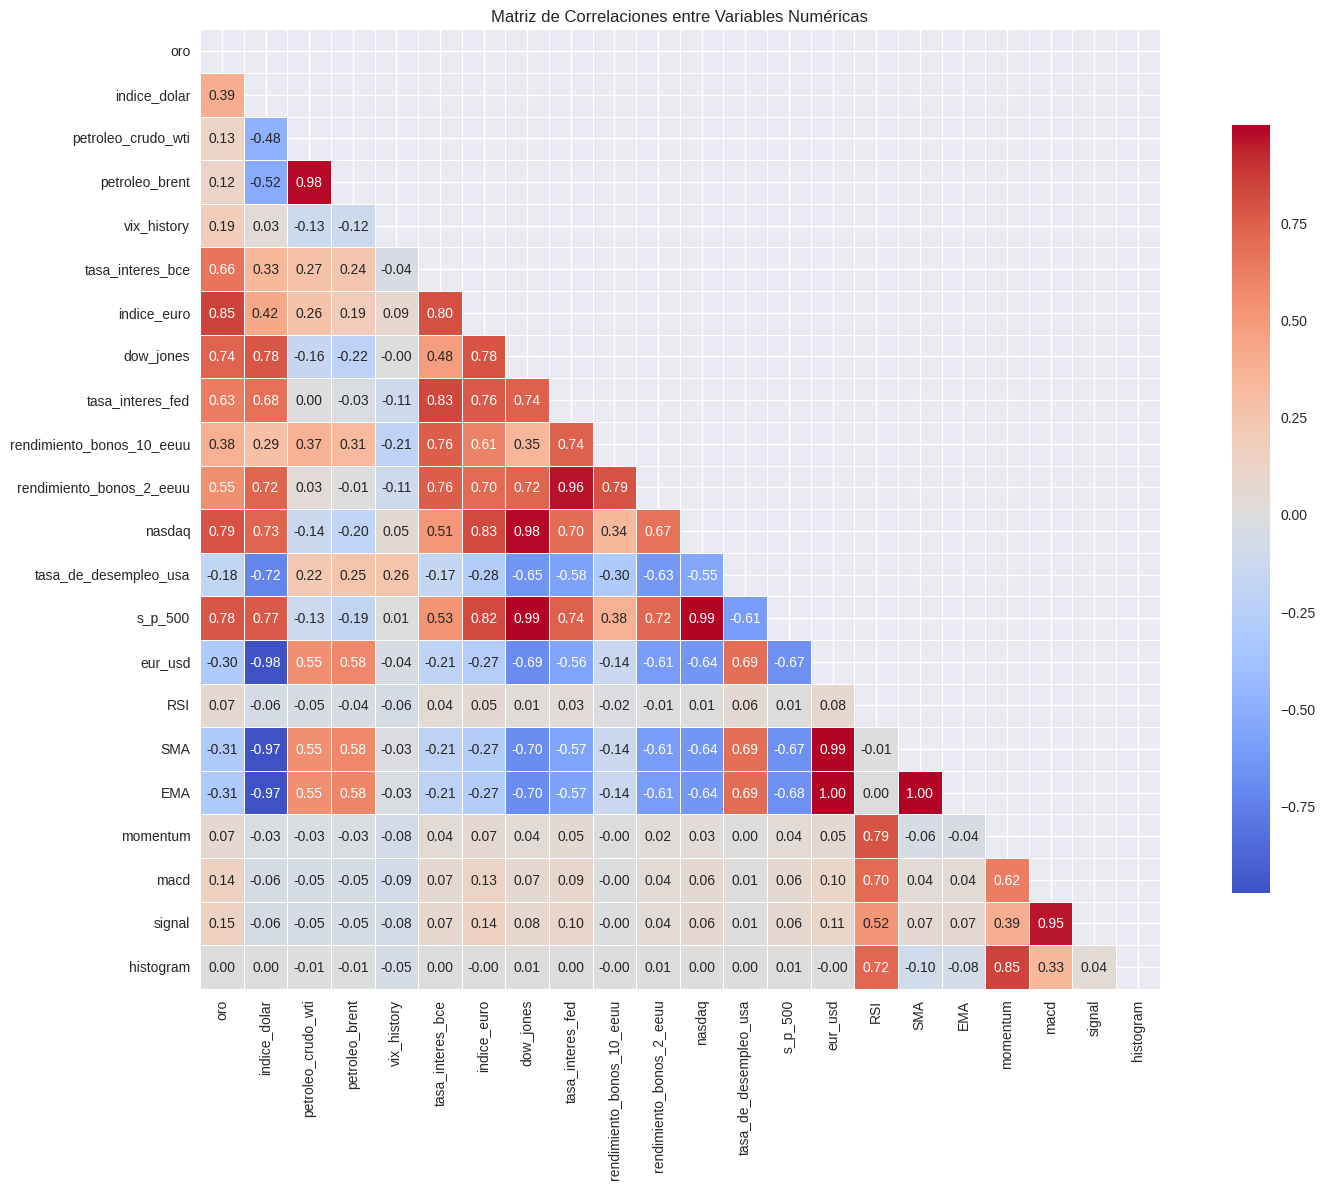

Variables numéricas analizadas: 22
Variables incluidas: ['oro', 'indice_dolar', 'petroleo_crudo_wti', 'petroleo_brent', 'vix_history', 'tasa_interes_bce', 'indice_euro', 'dow_jones', 'tasa_interes_fed', 'rendimiento_bonos_10_eeuu', 'rendimiento_bonos_2_eeuu', 'nasdaq', 'tasa_de_desempleo_usa', 's_p_500', 'eur_usd', 'RSI', 'SMA', 'EMA', 'momentum', 'macd', 'signal', 'histogram']


In [26]:
# Correlation matrix between all variables
# This helps us identify linear relationships between variables
# and detect possible multicolinerality
print("Análisis De Correlaciones")

# Calculate correlation matrix
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

# Calculate correlation matrix only with numerical variables
correlation_matrix = df_numeric.corr()

# Visualization of the correlation matrix
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Matriz de Correlaciones entre Variables Numéricas')
plt.tight_layout()
plt.show()

print(f"Variables numéricas analizadas: {len(numeric_columns)}")
print(f"Variables incluidas: {list(numeric_columns)}")

## Analysis of the correlation matrix

The Heatmap shows the correlations between multiple macroeconomic, market and technique variables. Here are the most relevant points:

### 1. Strong correlations (│r│> 0.70)

- ** EUR/USD VS Dollar Index (`Index_Dolar`) **:  
  R ≈ –0.98  
  → Almost perfect negative correlation: when the dollar is strengthened, the Eur/USD torque falls, and vice versa.

- ** WTI vs Brent oil **:  
  R ≈ 0.98  
  → Both crude prices move practically in tandem.

- ** Euro index (`index_euro`) vs Eur/usd **:  
  R ≈ +0.80  
  → Strengthens the relationship with the index wrong to the dollar: a stronger euro in its local index coincides with a high EUR/USD.

- ** US equities **  
  - S&P500 vs Nasdaq: R ≈ 0.99  
  - Dow Jones vs S & P500: R ≈ 0.99  
  - Nasdaq vs Dow Jones: R ≈ 0.98  
  → very high interdependence between the main stock market indices of the US.

- ** Interest rates in the short and long term of the US **  
  - Bonuses 2 years vs fed rate: r ≈ 0.83  
  - 10 years vs fed rate: r ≈ 0.74  
  - 10 years bonds vs 2 years: r ≈ 0.96  
  → Bond yields and Fed reference rate move very parallel.

- ** EUR/USD technical indicators **  
  - Sma vs Ema: R ≈ 1.00  
  - EMA VS EUR/USD (PRICE): R ≈ 0.69  
  - Sma vs Eur/USD: R ≈ 0.69  
  - `Signal` vs` macd`: r ≈ 0.95  
  → Many technical signals are almost redundant to each other.

### 2. Moderate correlations (│r│ between 0.40 and 0.70)

- ** EUR/USD vs.euu equities **  
  - vs Dow Jones: R ≈ –0.69  
  - vs nasdaq: r ≈ –0.61  
  - VS S&P500: R ≈ –0.64  
  → Appreciation of US actions usually accompanies a drop of the EUR/USD, which suggests rotation to “safe” assets in USD.

- ** EUR/USD vs USA Unemployment Rate **:  
  R ≈ –0.61  
  → Unemployment low (more solid economy) coincides with a stronger dollar and low USD.

- ** EUR/USD vs BCE rate **:  
  R ≈ –0.21  
  → Weak relationship: ECB decisions are reflected in EUR/USD but with less force than the index dollar or US rates.

- ** Other commodities and volatility **  
  - Gold vs Eur/USD: R ≈ –0.30  
  - Vix vs EUR/USD: R ≈ –0.04  
  → A little weaker: "shelters" as gold or implicit volatility do not have such a marked relationship.

### 3. Practical implications

1. ** Redundancy of variables **  
   - Many stock market rates and bond yields are almost colineal.  
   - Sma and Ema, or Macd and Signal, provide very similar information.  

   _ SUGGESTED ACTION_:  
   - Use ** Selection of variables ** (E.G. Lasso) or ** PCA ** to reduce dimensionality.  
   - Keep only one of each highly correlated "group".

2. ** Key variables for the model **  
   - The ** dollar index ** (or its inverse) is the most powerful predictor of EUR/USD.  
   - The ** interest rates of the US ** and the ** unemployment rate ** also have a relevant signal.  
   - ** Equities ** Provide information on appetite for risk and capital flow.

3. ** Care with multicolinerality **  
   - If you use linear algorithms (regression, Arima with regrators), monitor the ** vif ** of your features.  
   - In trees -based models (Random Forest, XGBOOST), multicolinerality affects less, but can dilute the importance of variables.

In [27]:
# Correlations with objective variable
# Identify more correlated variables with the target
target_correlations = correlation_matrix[target_col].abs().sort_values(ascending=False)
print(f"Top 10 Correlaciones Con {target_col}")
print(target_correlations.head(10))

# Multicolinerality detection
# Identify pairs of highly correlated variables (multicolinerality)
print("Detección De Multicolinealidad")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i],
                                   correlation_matrix.columns[j],
                                   correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("Pares de variables con correlación > 0.8:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print("No se encontraron correlaciones > 0.8 entre variables")

Top 10 Correlaciones Con eur_usd
eur_usd                     1.000000
EMA                         0.995171
SMA                         0.993335
indice_dolar                0.975337
dow_jones                   0.691676
tasa_de_desempleo_usa       0.691053
s_p_500                     0.670559
nasdaq                      0.636124
rendimiento_bonos_2_eeuu    0.607328
petroleo_brent              0.579661
Name: eur_usd, dtype: float64
Detección De Multicolinealidad
Pares de variables con correlación > 0.8:
oro - indice_euro: 0.853
indice_dolar - eur_usd: -0.975
indice_dolar - SMA: -0.972
indice_dolar - EMA: -0.973
petroleo_crudo_wti - petroleo_brent: 0.981
tasa_interes_bce - indice_euro: 0.802
tasa_interes_bce - tasa_interes_fed: 0.833
indice_euro - nasdaq: 0.826
indice_euro - s_p_500: 0.823
dow_jones - nasdaq: 0.984
dow_jones - s_p_500: 0.992
tasa_interes_fed - rendimiento_bonos_2_eeuu: 0.962
nasdaq - s_p_500: 0.994
eur_usd - SMA: 0.993
eur_usd - EMA: 0.995
SMA - EMA: 1.000
momentum - histo

## Multicolineality detection

After calculating the correlations, we identify the following pairs of variables with coefficient │r│> 0.80:


1. ** SMA - Ema: ** R = +1,000  
2. ** EUR/USD - EMA: ** R = +0.995  
3. ** Nasdaq - S & P500: ** R = +0.994  
4. ** EUR/USD - SMA: ** R = +0.993  
5. ** Dowjones - S&P500: ** R = +0.992  
6. ** Dowjones - Nasdaq: ** R = +0.984  
7. ** WTI - Brent: ** R = +0.981  
8. ** Dollar index - EUR/USD: ** R = –0.975  
9. ** Dollar index - Ema: ** R = –0.973  
10. ** Dollar index - Sma: ** R = –0.972  
11. ** FED RATE - PERFORMANCE 2 years (USA): ** R = +0.962  
12. ** Macd - Signal: ** R = +0.955  
13. ** Gold - Euro Index: ** R = +0.853  
14. ** Momentum - Macd histogram: ** R = +0.848  
15. ** BCE RATE - FED RATE: ** R = +0.833  
16. ** EURO - NASDAQ INDEX: ** R = +0.826  
17. ** EURO - S & P500 Index: ** R = +0.823  
18. ** BCE rate - Euro index: ** R = +0.802  

---

### 1. Grouping of redundant variables

1. ** US stock indexes **  
   - Dow Jones, Nasdaq and S&P500 are practically unison (R ≥ 0.98).  

2. ** Mobile socks and price **  
   - SMA, EMA and EUR/USD are almost perfectly correlated (R ≥ 0.99).  
   - Macd and Signal also almost identical (R = 0.955).  

3. ** Energy references **  
   - WTI vs Brent (R = 0.981) show the same crude oil dynamics.  

4. ** Monetary policy and bonds **  
   - Fed Rate vs Performance Bonds 2 years (r = 0.962) and BCE vs. fed rate/euro index also very high.  

5. ** Other couples **  
   - Gold vs. Euro Index, Momentum vs Macd Histogram, Index Dollar Vs Price/Mobile Medias.

---

### 2. Why is it important to reduce multicolinerality?

- ** In linear models ** (regression, arima with regulars) multicolinerality:  
  - Infla the variance of the coefficients.  
  - Estimates makes unstable and hinders the interpretation of the importance of each predictor.

- ** In trees -based models or ML advanced **, multicolinerality:  
  - It does not affect the accuracy so much, but it can disperse the importance of variables and complicate the analysis of "feature importance."

---

### 3. Strategies to mitigate it

1. ** Manual selection of variables **  
   - Keep a single representative of each highly correlated group (for example, only S&P500 instead of the three indices).  
   - Choose between SMA or Ema according to preference for softening.  

2. ** Creation of compound indicators **  
   - Group WTI and Brent in an ** average crude price **.  
   - Calculate the ** spread 10a2 years ** instead of using both rates individually.  

3. ** Automatic methods **  
   - ** Lasso (L1 penalty) ** to penalize and eliminate redundant variables.  
   - ** Main component analysis (PCA) ** To reduce dimension and capture most of the variance in few components without colineality.

4. ** VIF review **  
   - Calculate the ** VARIance inflation factor ** to quantify the multicolinerality of each variable and decide exclusion thresholds.

## Distribution analysis

The distribution analysis is crucial for:

### Normality evaluation:
- ** Many models assume normality ** (linear regression, some statistical methods)
- ** Normality tests ** identify significant deviations
- ** Transformations ** can normalize asymmetric distributions

### Distribution abnormalities:
-*skewness **: asymmetry towards high/low values
- ** Kurtosis **: "Thick queues" - greater probability of extreme values
- ** Bimodality **: Multiple regimes in the data

### Modeling implications:
- ** Normal distributions **: Linear models, appropriate MSE Metric
- ** Thick queues **: Consider robust, metric models like mae
- ** Marked Asymmetry **: Log, Box-Cox Transformations

### Tests implemented:
- ** Jarque-Bera **: Based on Skewness and Kurtosis
- ** Shapiro-Wilk **: More powerful for small samples
- ** d'Agostino **: robust alternative

### Q-q plot:
Compare quantiles observed vs. Theoretical (normal distribution):
- ** Straight line **: Normal distribution
- ** Curvature **: systematic deviations of normality
""

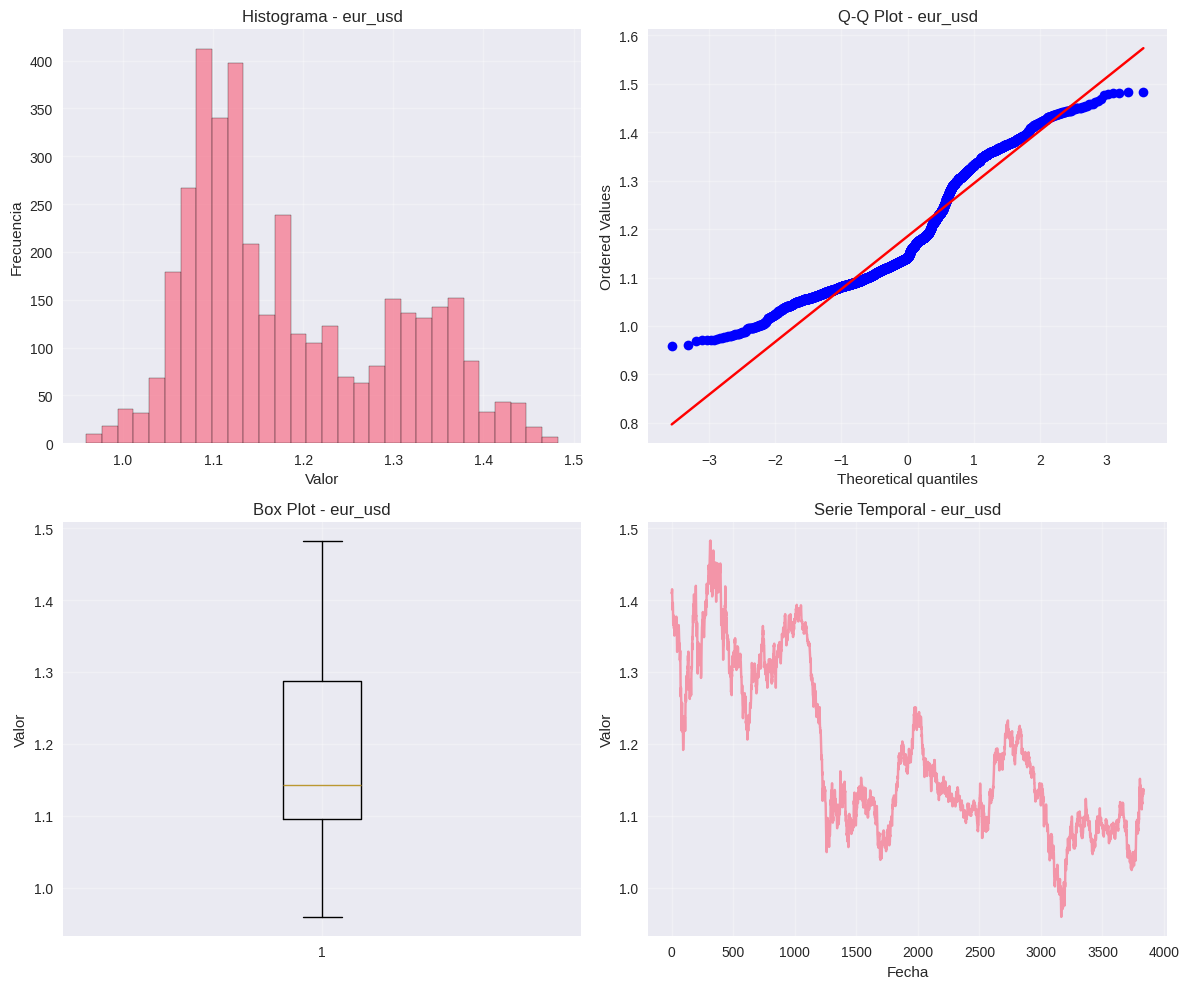

Tests De Normalidad Para eur_usd
Jarque-Bera: estadístico=323.7842, p-valor=0.0000
Shapiro-Wilk: estadístico=0.9271, p-valor=0.0000
D'Agostino: estadístico=499.9708, p-valor=0.0000
✗ La distribución NO es normal (Jarque-Bera)
Estadísticas descriptivas:
Media: 1.1852
Mediana: 1.1426
Desviación estándar: 0.1131
Skewness: 0.5927
Kurtosis: -0.7885




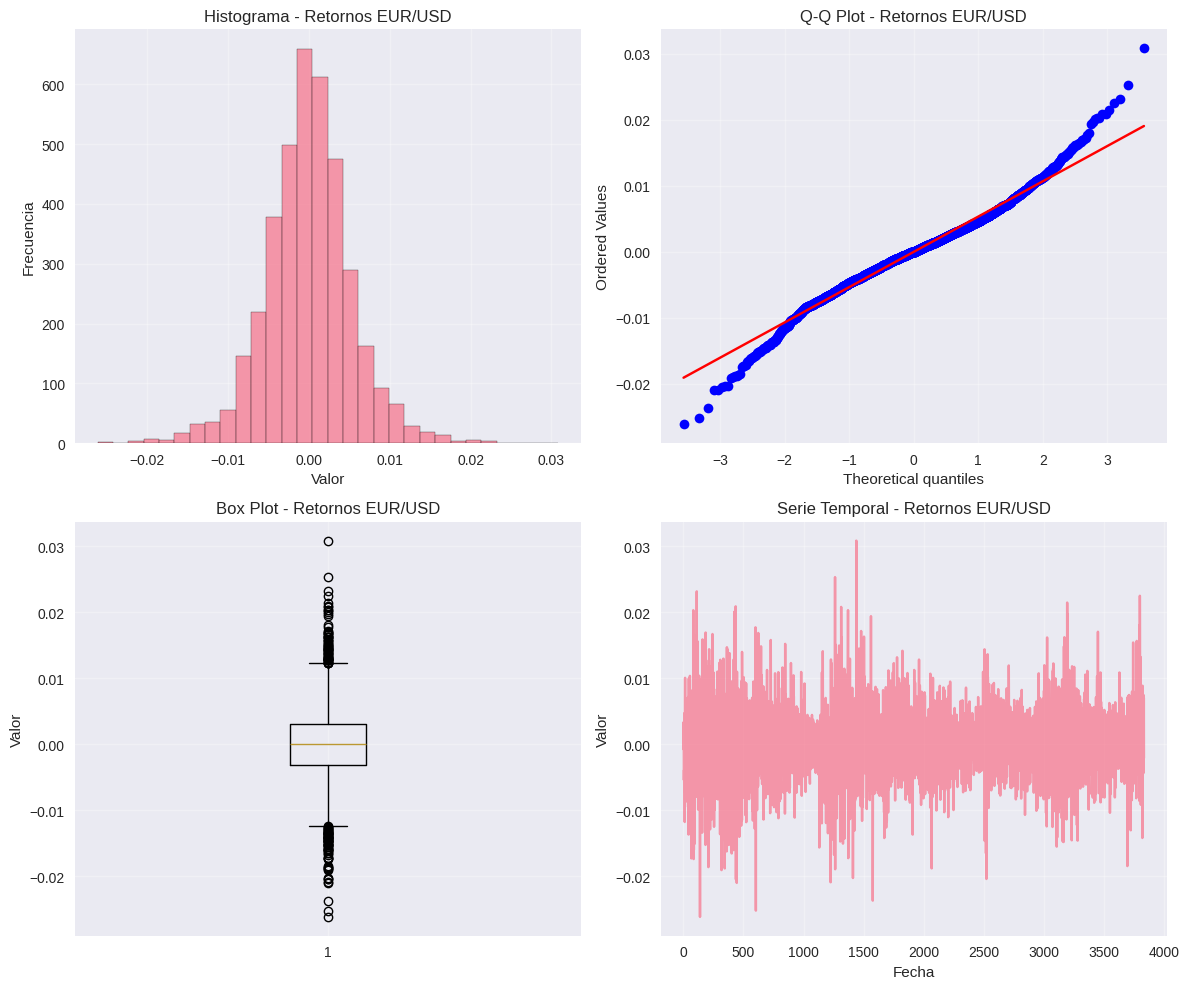

Tests De Normalidad Para Retornos EUR/USD
Jarque-Bera: estadístico=582.1264, p-valor=0.0000
Shapiro-Wilk: estadístico=0.9814, p-valor=0.0000
D'Agostino: estadístico=171.4106, p-valor=0.0000
✗ La distribución NO es normal (Jarque-Bera)
Estadísticas descriptivas:
Media: -0.0000
Mediana: 0.0000
Desviación estándar: 0.0054
Skewness: 0.0100
Kurtosis: 1.9131




In [28]:
# Distribution analysis function
def analyze_distribution(data, title):
    """
    Función para analizar la distribución de una variable
    Incluye tests de normalidad y visualizaciones diagnósticas
    """
    # Eliminate null values
    clean_data = data.dropna()

    # Create Sublots for Complete Visual Analysis
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Histogram - shows the form of distribution
    axes[0,0].hist(clean_data, bins=30, alpha=0.7, edgecolor='black')
    axes[0,0].set_title(f'Histograma - {title}')
    axes[0,0].set_xlabel('Valor')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].grid(True, alpha=0.3)

    # Q -Q plot - Compare with normal theoretical distribution
    stats.probplot(clean_data, dist="norm", plot=axes[0,1])
    axes[0,1].set_title(f'Q-Q Plot - {title}')
    axes[0,1].grid(True, alpha=0.3)

    # Box Plot - identifies outliers and quartiles
    axes[1,0].boxplot(clean_data)
    axes[1,0].set_title(f'Box Plot - {title}')
    axes[1,0].set_ylabel('Valor')
    axes[1,0].grid(True, alpha=0.3)

    # TEMPORARY SERIES - EVOLUTION IN TIME
    axes[1,1].plot(clean_data.index, clean_data, alpha=0.7)
    axes[1,1].set_title(f'Serie Temporal - {title}')
    axes[1,1].set_xlabel('Fecha')
    axes[1,1].set_ylabel('Valor')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical Normality Tests
    print(f"Tests De Normalidad Para {title}")

    # Jarque-Bere test
    jb_stat, jb_pvalue = jarque_bera(clean_data)
    print(f"Jarque-Bera: estadístico={jb_stat:.4f}, p-valor={jb_pvalue:.4f}")

    # Shapiro-Wilk test (for small samples)
    if len(clean_data) <= 5000:
        sw_stat, sw_pvalue = shapiro(clean_data)
        print(f"Shapiro-Wilk: estadístico={sw_stat:.4f}, p-valor={sw_pvalue:.4f}")

    # D'Agostino test
    da_stat, da_pvalue = normaltest(clean_data)
    print(f"D'Agostino: estadístico={da_stat:.4f}, p-valor={da_pvalue:.4f}")

    # Interpretation of results
    if jb_pvalue > 0.05:
        print("✓ La distribución parece ser normal (Jarque-Bera)")
    else:
        print("✗ La distribución NO es normal (Jarque-Bera)")

    # Descriptive statistics of form
    print(f"Estadísticas descriptivas:")
    print(f"Media: {clean_data.mean():.4f}")
    print(f"Mediana: {clean_data.median():.4f}")
    print(f"Desviación estándar: {clean_data.std():.4f}")
    print(f"Skewness: {clean_data.skew():.4f}")
    print(f"Kurtosis: {clean_data.kurtosis():.4f}")
    print("\n" + "="*50 + "\n")

# Analyze the distribution of the objective variable
analyze_distribution(df[target_col], target_col)

# Analyze the distribution of returns
analyze_distribution(returns, 'Retornos EUR/USD')

## Outliers detection

Outliers in financial data require special analysis because:

### Types of outliers in finance:
- ** Market events **: crisis, important ads, monetary policy decisions
- ** Data errors **: Technical problems, incorrect feeds
- ** Legitimate extreme movements **: Natural part of market volatility

### Detection methods:
- ** IQR (interquartilic range) **: Q3 + 1.5*IQR, robust to asymmetric distributions
- ** Z-SCORE **: Based on standard deviations, assume normal distribution

### Critical decisions:
- ** Remove or maintain? **: Extreme events can be informative for the model
- ** Transform? **: Winsorization, Capping
- ** Model separately? **: Specific models for extreme regimes

### Implications:
- ** Outliers in price **: They can indicate regime changes
- ** Outliers in returns **: Events that affect volatility
- ** Temporary clustering **: Outliers tend to group in periods of crisis

### Special consideration:
In finance, outliers "are often the most important events to predict (crisis, bubbles).

Detección De Outliers - eur_usd
Método: IQR
Número de outliers: 0
Porcentaje de outliers: 0.00%


Detección De Outliers - eur_usd
Método: ZSCORE
Número de outliers: 0
Porcentaje de outliers: 0.00%


Detección De Outliers - Retornos EUR/USD
Método: IQR
Número de outliers: 139
Porcentaje de outliers: 3.63%
Fechas con outliers más extremos:
  1439: 0.0308
  138: 0.0262
  1262: 0.0253
  603: 0.0252
  1576: 0.0237


Detección De Outliers - Retornos EUR/USD
Método: ZSCORE
Número de outliers: 46
Porcentaje de outliers: 1.20%
Fechas con outliers más extremos:
  1439: 0.0308
  138: 0.0262
  1262: 0.0253
  603: 0.0252
  1576: 0.0237




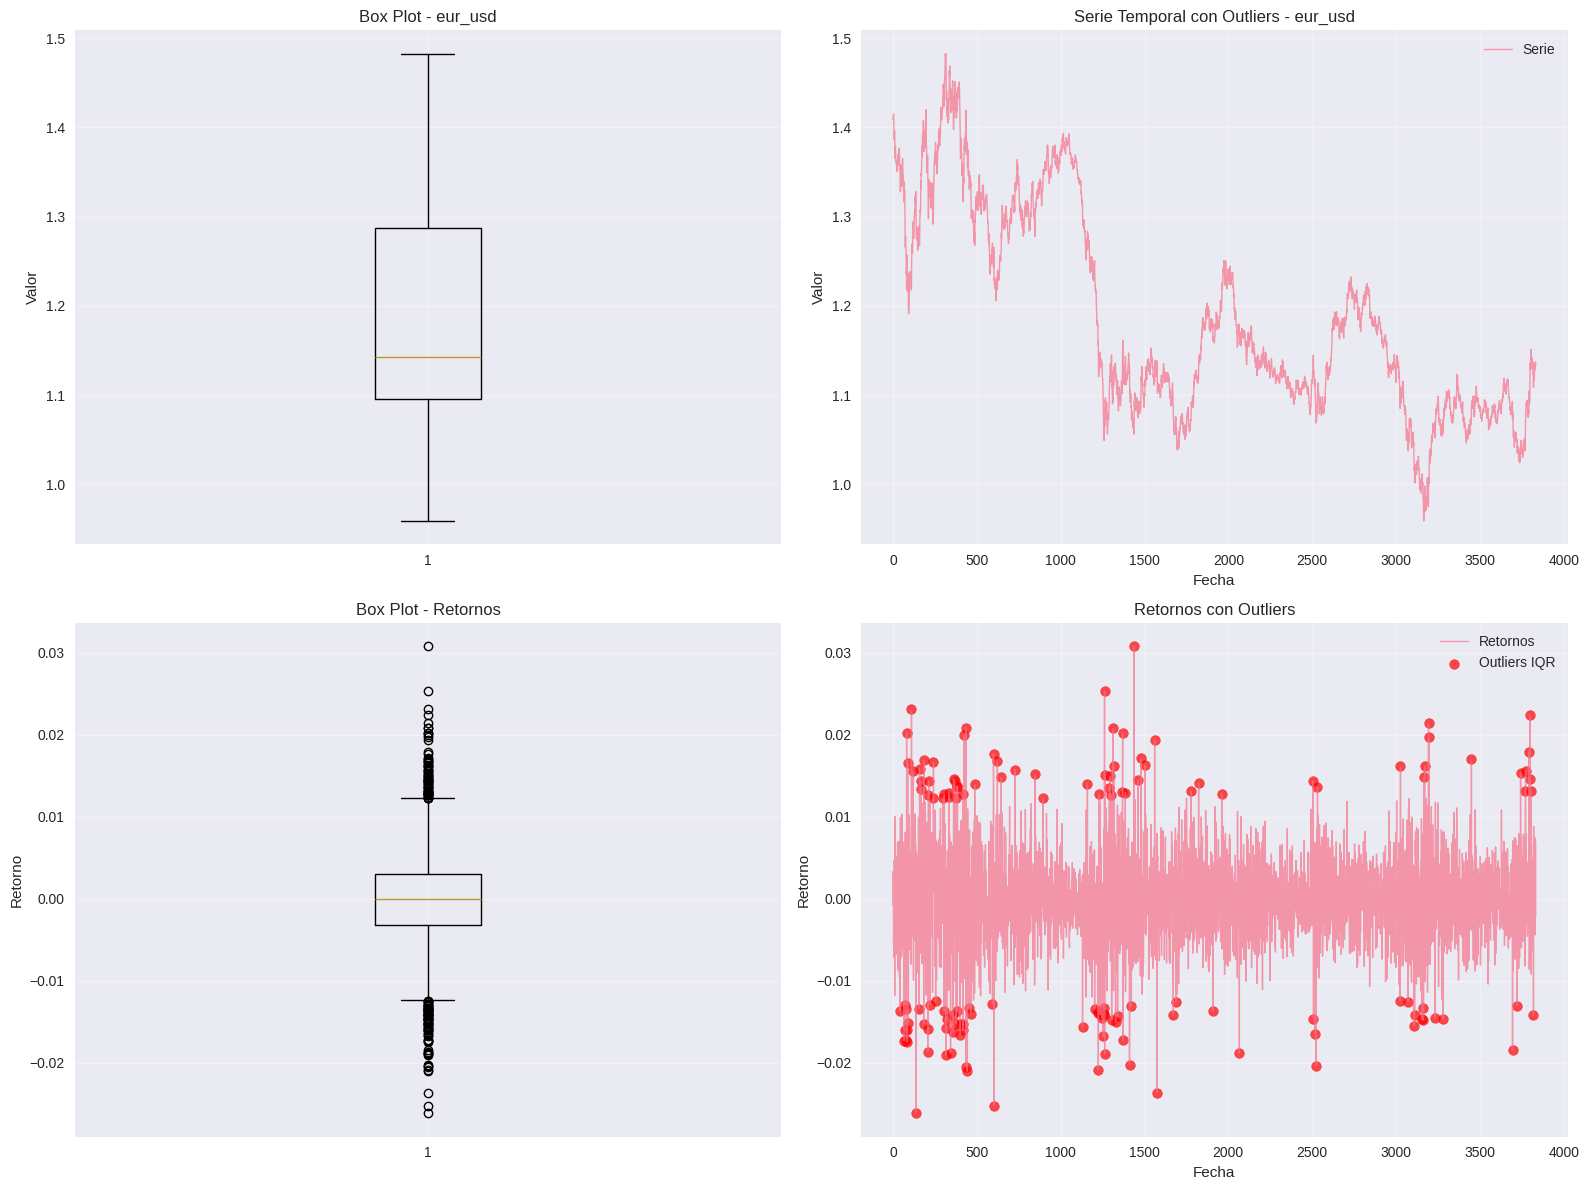

In [29]:
# Outliers detection function
def detect_outliers(data, method='iqr', title='Variable'):
    """
    Función para detectar outliers usando diferentes métodos
    Retorna índices y valores de outliers identificados
    """
    clean_data = data.dropna()

    if method == 'iqr':
        # Interquartile Rank Method
        Q1 = clean_data.quantile(0.25)
        Q3 = clean_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]

    elif method == 'zscore':
        # Z-SCORE-based method (3 standard deviations)
        z_scores = np.abs(stats.zscore(clean_data))
        outliers = clean_data[z_scores > 3]

    print(f"Detección De Outliers - {title}")
    print(f"Método: {method.upper()}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentaje de outliers: {(len(outliers)/len(clean_data))*100:.2f}%")

    if len(outliers) > 0:
        print(f"Fechas con outliers más extremos:")
        for date, value in outliers.abs().sort_values(ascending=False).head(5).items():
            print(f"  {date}: {value:.4f}")

    print("\n" + "="*30 + "\n")
    return outliers

# OUTLIEERS OBJECT OBJECT DETECTION
# Detect outliers in the target variable using both methods
outliers_iqr = detect_outliers(df[target_col], 'iqr', target_col)
outliers_zscore = detect_outliers(df[target_col], 'zscore', target_col)

# Outliers detection returns
# Detect outliers in returns (more relevant for financial analysis)
outliers_returns_iqr = detect_outliers(returns, 'iqr', 'Retornos EUR/USD')
outliers_returns_zscore = detect_outliers(returns, 'zscore', 'Retornos EUR/USD')

# Outliers visualization
# Comprehensive visualization of identified outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot for the target variable
axes[0,0].boxplot(df[target_col].dropna())
axes[0,0].set_title(f'Box Plot - {target_col}')
axes[0,0].set_ylabel('Valor')
axes[0,0].grid(True, alpha=0.3)

# Temporary series with marked outliers
axes[0,1].plot(df.index, df[target_col], linewidth=1, alpha=0.7, label='Serie')
if len(outliers_iqr) > 0:
    axes[0,1].scatter(outliers_iqr.index, outliers_iqr.values,
                      color='red', s=50, alpha=0.7, label='Outliers IQR')
axes[0,1].set_title(f'Serie Temporal con Outliers - {target_col}')
axes[0,1].set_xlabel('Fecha')
axes[0,1].set_ylabel('Valor')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot box for returns
axes[1,0].boxplot(returns.dropna())
axes[1,0].set_title('Box Plot - Retornos')
axes[1,0].set_ylabel('Retorno')
axes[1,0].grid(True, alpha=0.3)

# Returns with outliers
axes[1,1].plot(returns.index, returns, linewidth=1, alpha=0.7, label='Retornos')
if len(outliers_returns_iqr) > 0:
    axes[1,1].scatter(outliers_returns_iqr.index, outliers_returns_iqr.values,
                      color='red', s=50, alpha=0.7, label='Outliers IQR')
axes[1,1].set_title('Retornos con Outliers')
axes[1,1].set_xlabel('Fecha')
axes[1,1].set_ylabel('Retorno')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Autocorrelation analysis

Autocorrelation measures the relationship of a series with itself at different points of time:

### Fundamental concepts:
- ** ACF (Autocorrelation Function) **: Correlation between x (t) and x (t-k) for different k lags
- ** PACF (partial Autocorrelation Function) **: Correlation between x (t) and x (t-k) eliminating the effect of intermediate lags

### Interpretation in finance:
- ** ACF High in Lag 1 **: Trend, Momentum in prices
- ** ACF decaying slowly **: non -stationary series
- ** ACF with abrupt cuts **: possible ma model
- ** PACF with abrupt cuts **: possible ar model

### Practical applications:
- ** Identification of Arima Models **: Order ar, ma
- ** Memory detection **: Are past values influence futures?
- ** Market efficiency **: Are returns predictable?

### Independence tests:
- ** LJung-Box **: H0 = No Autocorrelation until Lag K
- ** Fundamental in Finance **: Returns should be independent (efficient market hypothesis)

### Modeling implications:
- ** High Autocorrelation **: Self -giving models (AR, Arima)
- ** Autocorrelation in returns **: Viola market efficiency, prediction opportunity
- ** Autocorrelation in volatility **: Models necessary

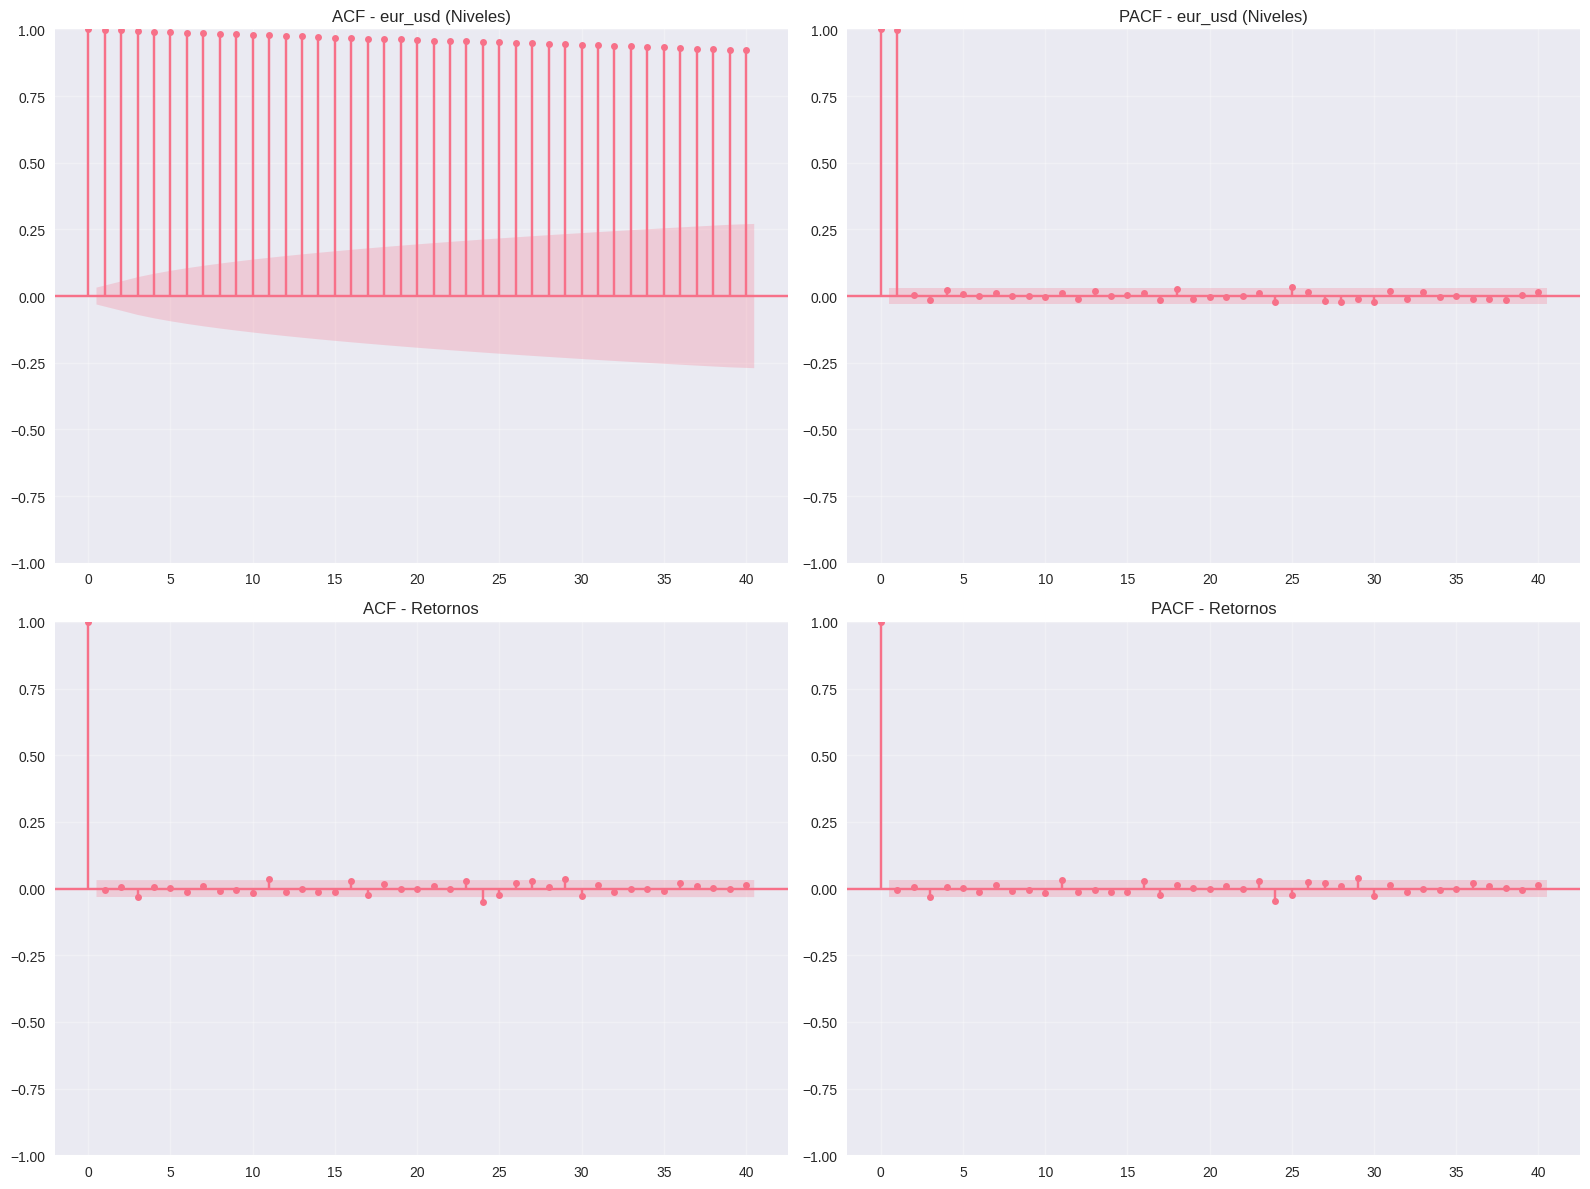

In [30]:

# Import for autocorrelation
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF graphics
# Autocorrelation Function (ACF) and Partial Autocorrelation (PACF)
# These graphics are fundamental to identify temporary patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ACF for the original series (levels)
plot_acf(df[target_col].dropna(), ax=axes[0,0], lags=40, alpha=0.05)
axes[0,0].set_title(f'ACF - {target_col} (Niveles)')
axes[0,0].grid(True, alpha=0.3)

# PACF for the original series (levels)
plot_pacf(df[target_col].dropna(), ax=axes[0,1], lags=40, alpha=0.05)
axes[0,1].set_title(f'PACF - {target_col} (Niveles)')
axes[0,1].grid(True, alpha=0.3)

# ACF for returns (more relevant for prediction)
plot_acf(returns.dropna(), ax=axes[1,0], lags=40, alpha=0.05)
axes[1,0].set_title('ACF - Retornos')
axes[1,0].grid(True, alpha=0.3)

# PACF for returns
plot_pacf(returns.dropna(), ax=axes[1,1], lags=40, alpha=0.05)
axes[1,1].set_title('PACF - Retornos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ACF and PACF analysis



1. ** Original series (EUR/USD levels) **  
   - ** ACF (levels): **  
     - It is maintained ** well above ** of the trust limit (± 1.96/√n) for dozens of lag.  
     - Very slow decay ("long tail"), typical of series ** non -stationary **.  
   - ** PACF (levels): **  
     - Very large peak in the ** Lag1 **, then practically all the other lags fall within the confidence interval.  
     - It suggests that, after a single difference, the series could become stationary (authorship component of order 1).

2. ** Daily returns **  
   - ** ACF (returns): **  
     - Great peak in ** Lag0 ** (perfect correlation with itself) and ** Lag1 ** almost zero, the rest remains inside the band.  
     - Sign that ** There is no significant autocorrelation ** beyond zero lag, close behavior to white noise.  
   - ** Pacf (returns): **  
     - Very small residual peak in ** Lag1 **, then everything inside.  
     - Indicates that an ** ar (1) ** (or even without self -revital terms) could be sufficient to capture the minimum dependence.

---

### Implications for modeling

- ** EUR/usd levels **: Slow acf and PACF with only significant LAG1 confirm non -parking. It is necessary to differentiate or work directly with returns before modeling.  
- ** Returns **: practically _White noise_ with very little serial dependence.  
  - A ** Arima (1,0,0) ** (AR (1) on returns) would capture the small peak in Lag1, but a lags could also work.  
  - For ** Machine Learning **, these low levels of autocorrelation imply that the ** Já Lagatos de Returos ** alone provide little signal, so it is convenient to enrich the dataset with ** exogenous features ** (technical indicators, macro variables, spreds, etc.).

## Momentum analysis and technical indicators

Technical indicators are fundamental in financial analysis because:

### Philosophy of technical analysis:
- ** All information is in the price **: prices reflect all available information
- ** prices move in trends **: trends tend to persist
- ** History is repeated **: past patterns can be repeated

### Indicators implemented:

#### Mobile stockings:
- ** SMA (Simple Moving avenge) **: Aryithmetic pricing average
- ** Crossing signs **: Price vs. Media, short medium vs. long medium
- ** Tendency identification **: Price on/low average indicates trend

#### RSI (relative strength index):
- ** Momentum oscillator **: It measures speed and price movements
- ** RANGE 0-100 **:> 70 OVERL
- ** Divergences **: RSI vs. price can indicate reversions

#### MacD (MOVING AVERAGE CONVERGENCE DIVERGENCE):
- ** Macd line **: Ema (12) - Ema (26)
- ** Signal line **: EMA (9) of the MACD line
- ** Histogram **: MacD - Signal
- ** Cruces **: generate purchase/sale signals

### Persistence analysis:
- ** Momentum **: Do positive returns continue to positive returns?
- ** Reversion to average **: Do prices return to historical levels?
- ** Serial correlation **: Temporary dependence on returns

### Practical applications:
- ** Input/output timing **: When to buy/sell
- ** Confirmation of trends **: Validate fundamental signals
-** Risk Management **: Stop -los, Take-Profit
- ** Signal filters **: Avoid false signals
""

Análisis De Momentum E Indicadores Técnicos
RSI calculado
MACD calculado
Análisis De Persistencia De Momentum
Correlaciones seriales por lag:
  Lag 1 días: -0.0039
  Lag 3 días: -0.0332
  Lag 5 días: 0.0029
  Lag 10 días: -0.0182
  Lag 20 días: -0.0008
✗ No se detecta persistencia significativa de corto plazo


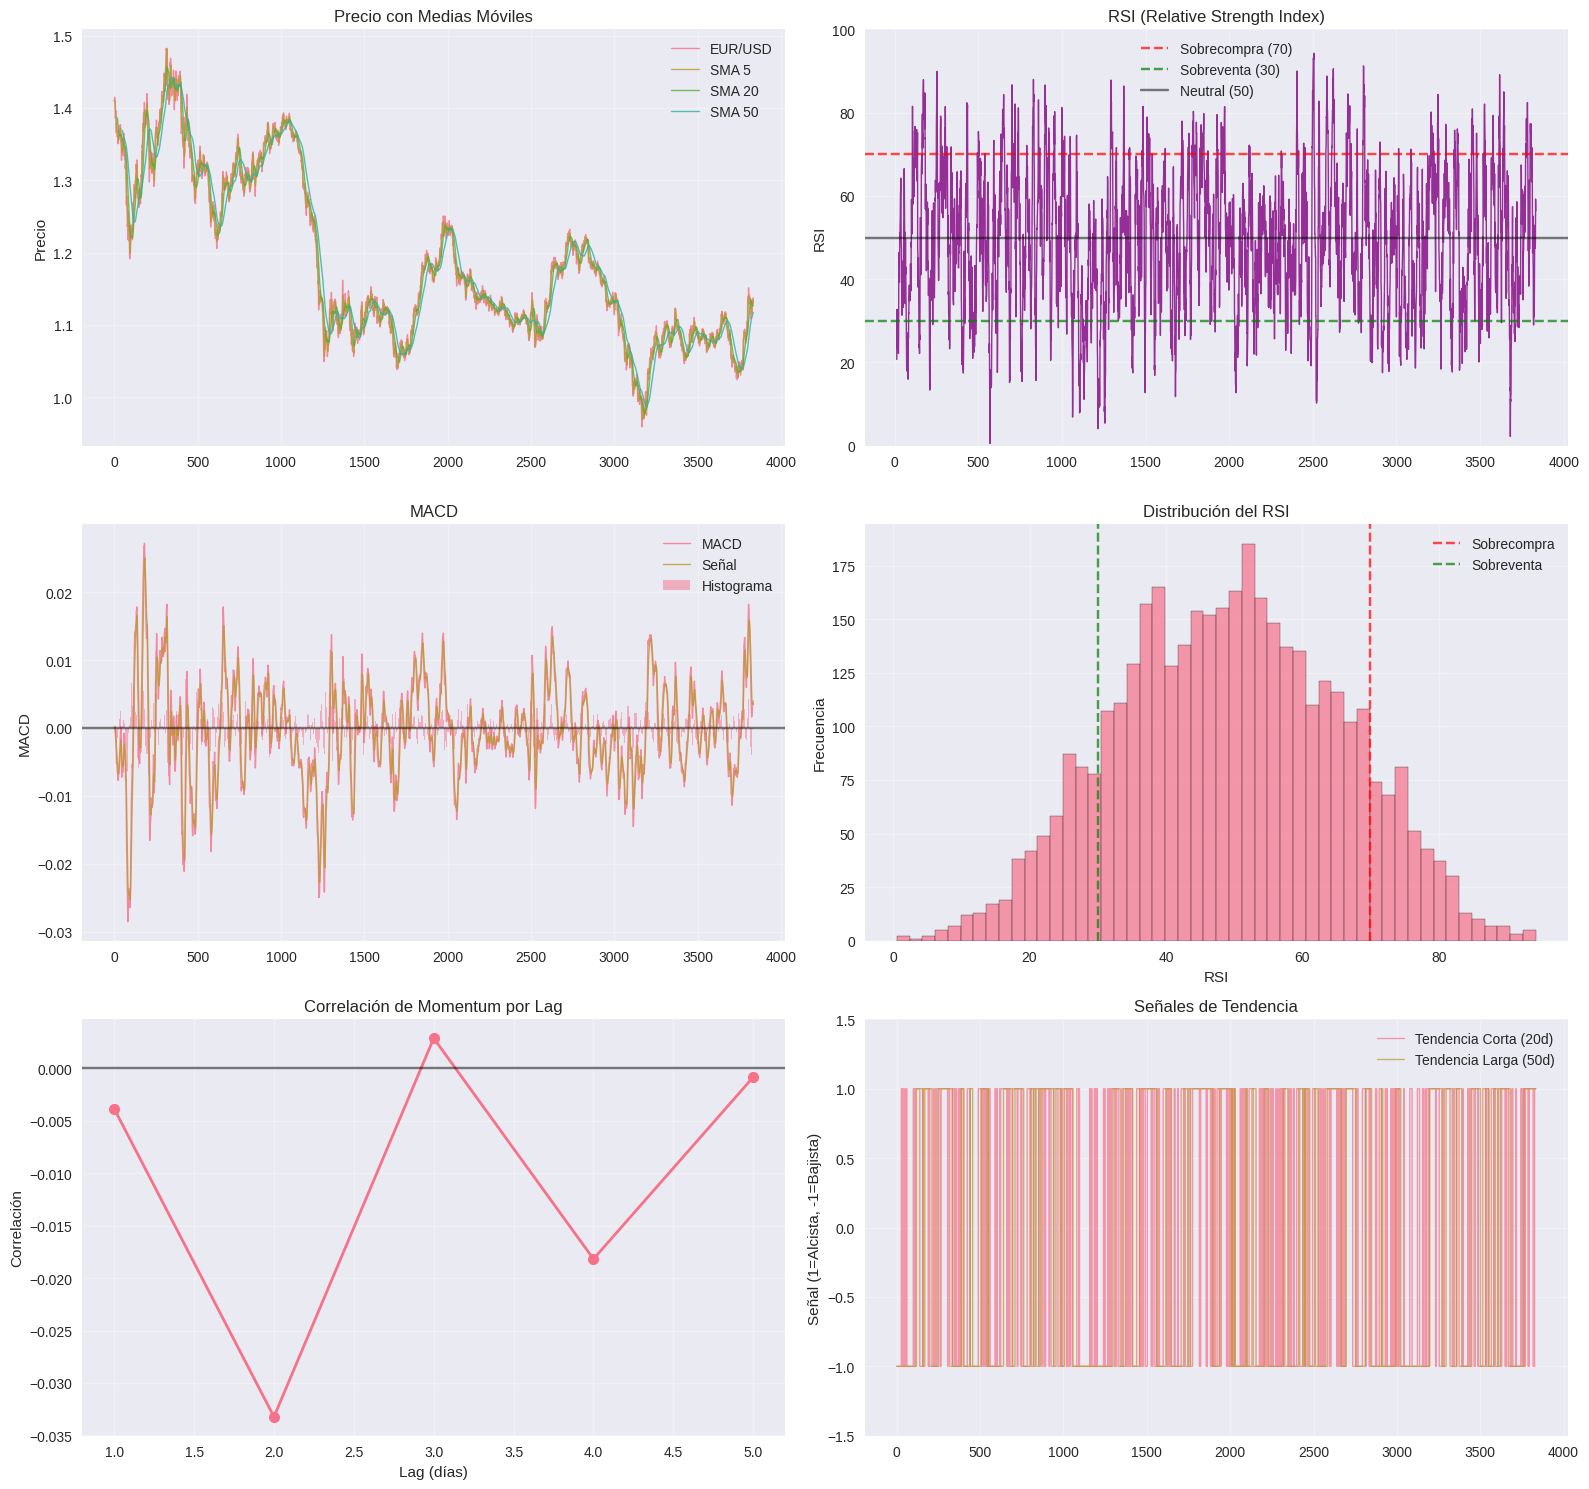

In [31]:
# Calculation Technical indicators
print("Análisis De Momentum E Indicadores Técnicos")

# Create DataFrame for Momentum Analysis
df_momentum = df.copy()

# Simple mobile socks for different horizons
df_momentum['sma_5'] = df_momentum[target_col].rolling(window=5).mean()   # 1 week
df_momentum['sma_10'] = df_momentum[target_col].rolling(window=10).mean() # 2 weeks
df_momentum['sma_20'] = df_momentum[target_col].rolling(window=20).mean() # 1 month
df_momentum['sma_50'] = df_momentum[target_col].rolling(window=50).mean() # ~ 2.5 months

# Trend signals based on mobile socks
df_momentum['trend_short'] = np.where(df_momentum[target_col] > df_momentum['sma_20'], 1, -1)
df_momentum['trend_long'] = np.where(df_momentum['sma_20'] > df_momentum['sma_50'], 1, -1)

# RSI function
# Function to calculate RSI (relative strength index)
def calculate_rsi(prices, window=14):
    """
    Calcula el RSI para una serie de precios
    RSI = 100 - (100 / (1 + RS))
    RS = Average Gain / Average Loss
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_momentum['rsi'] = calculate_rsi(df_momentum[target_col])
print("RSI calculado")

# Macd function
# Function to calculate MacD
def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calcula MACD (Moving Average Convergence Divergence)
    MACD = EMA(fast) - EMA(slow)
    Signal = EMA(MACD, signal_period)
    Histogram = MACD - Signal
    """
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

df_momentum['macd'], df_momentum['macd_signal'], df_momentum['macd_histogram'] = calculate_macd(df_momentum[target_col])
print("MACD calculado")

# Momentum persistence analysis (serial correlation)
returns_momentum = df_momentum[target_col].pct_change()
momentum_correlations = []

print("Análisis De Persistencia De Momentum")
print("Correlaciones seriales por lag:")

for lag in [1, 3, 5, 10, 20]:
    corr = returns_momentum.corr(returns_momentum.shift(lag))
    momentum_correlations.append(corr)
    print(f"  Lag {lag} días: {corr:.4f}")

# Interpretation of results
if momentum_correlations[0] > 0.05:
    print("✓ Se detecta momentum positivo de corto plazo")
elif momentum_correlations[0] < -0.05:
    print("✓ Se detecta reversión a la media de corto plazo")
else:
    print("✗ No se detecta persistencia significativa de corto plazo")

# Comprehensive visualization of momentum analysis
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# Price with mobile socks
axes[0,0].plot(df_momentum.index, df_momentum[target_col], linewidth=1, label='EUR/USD', alpha=0.8)
axes[0,0].plot(df_momentum.index, df_momentum['sma_5'], linewidth=1, label='SMA 5', alpha=0.8)
axes[0,0].plot(df_momentum.index, df_momentum['sma_20'], linewidth=1, label='SMA 20', alpha=0.8)
axes[0,0].plot(df_momentum.index, df_momentum['sma_50'], linewidth=1, label='SMA 50', alpha=0.8)
axes[0,0].set_title('Precio con Medias Móviles')
axes[0,0].set_ylabel('Precio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# RSI with over -sales over -sales levels
axes[0,1].plot(df_momentum.index, df_momentum['rsi'], linewidth=1, color='purple', alpha=0.8)
axes[0,1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Sobrecompra (70)')
axes[0,1].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Sobreventa (30)')
axes[0,1].axhline(y=50, color='black', linestyle='-', alpha=0.5, label='Neutral (50)')
axes[0,1].set_title('RSI (Relative Strength Index)')
axes[0,1].set_ylabel('RSI')
axes[0,1].set_ylim(0, 100)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# MACD with signal and histogram line
axes[1,0].plot(df_momentum.index, df_momentum['macd'], linewidth=1, label='MACD', alpha=0.8)
axes[1,0].plot(df_momentum.index, df_momentum['macd_signal'], linewidth=1, label='Señal', alpha=0.8)
axes[1,0].bar(df_momentum.index, df_momentum['macd_histogram'], alpha=0.5, label='Histograma', width=1)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('MACD')
axes[1,0].set_ylabel('MACD')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# RSI distribution
axes[1,1].hist(df_momentum['rsi'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1,1].axvline(x=70, color='red', linestyle='--', alpha=0.7, label='Sobrecompra')
axes[1,1].axvline(x=30, color='green', linestyle='--', alpha=0.7, label='Sobreventa')
axes[1,1].set_title('Distribución del RSI')
axes[1,1].set_xlabel('RSI')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Momentum correlations by LAG
axes[2,0].plot(range(1, len(momentum_correlations)+1), momentum_correlations, 'o-',
               linewidth=2, markersize=8)
axes[2,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[2,0].set_title('Correlación de Momentum por Lag')
axes[2,0].set_xlabel('Lag (días)')
axes[2,0].set_ylabel('Correlación')
axes[2,0].grid(True, alpha=0.3)

# Trend signals
axes[2,1].plot(df_momentum.index, df_momentum['trend_short'], linewidth=1, alpha=0.7,
               label='Tendencia Corta (20d)', drawstyle='steps-post')
axes[2,1].plot(df_momentum.index, df_momentum['trend_long'], linewidth=1, alpha=0.7,
               label='Tendencia Larga (50d)', drawstyle='steps-post')
axes[2,1].set_title('Señales de Tendencia')
axes[2,1].set_ylabel('Señal (1=Alcista, -1=Bajista)')
axes[2,1].set_ylim(-1.5, 1.5)
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis of technical indicators and signals


### 1. Price with mobile socks (SMA 5, 20 and 50 days)  
- The three curves (5d in Ocher, 20D in light green and 50d in turquoise) are closely followed by the real price of the EUR/usd (pink), softening the short -term noise.  
- ** Medium Cruces **:  
  - When SMA 5 crosses up SMA 20 or 50, indicates possible ** Alcista signal ** short -term.  
  - Low crossings mark ** Whipist signal **.  
- We observe numerous intersections, reflection of a market with short trends and lateral "ranges".

---

### 2. RSI (relative strength index)  
- The RSI ranges between 0 and 100, with areas of ** overcompra ** (> 70) and ** overall ** (<30).  
- The series (purple) shows frequent peaks above 70 and falls below 30, suggesting rapid cycles of impulse and correction.  
- Reference lines:  
  - ** 70 ** (Potted red): overcompra threshold.  
  - ** 30 ** (Potted green): overall threshold.  
  - ** 50 ** (Gray): Neutral zone.

---

### 3. Macd (Moving avenge convergence divergence)  
- The MACD line (pink), the signal (ocher) and the histogram (pink semi -transparent background) are graphic.  
- The histogram, which is the MacD -point difference, highlights the ** Force and duration of the impulse **:  
  - Positive bars (above zero) indicate that the short -term trend exceeds the long one.  
  - Negative bars mark otherwise.  
- Relatively short impulse bursts alternate, compatible with a market without very long trends.

---

### 4. RSI distribution  
- RSI histogram shows the ** observations density ** at each level.  
- Most values are concentrated between ** 30 and 70 **, with fashion close to 45–55.  
- Relatively rarely reaches extremes (<20 or> 80), which suggests that although there are signs of overcompra/sale, the RSI spends more time in average range.

---

### 5. Momentum correlation by LAG (1–5 days)  
- The “momentum” graph (simple return or reore accumulated in _n_ days) shows ** very low negative correlations ** in lags 1–5:  
  - Lag2 presents the cor. more negative (~ –0.034), other lags close to zero.  
- Implication: the momentum of one to five days ** is not persistent **, almost does not predict the following movement.

---

### 6. Trend signs (SMA5 vs. Cruces Sma50)  
- Binary series with values **+1 = Alcista signal ** (5d> 50d) and ** - 1 = bearish signal ** (5d <50d).  
- Both signals (cut into pink and long in ocher) alternate high frequently, confirming a very noisy market ** and with short periods of defined trend.  

---

## Partial conclusions

1. ** High signal volatility **: Mobile socks cross frequently, generating many short -term inputs/outputs.  
2. ** RSI and MACD as accessories **:  
   - RSI identifies brief ends of overcompra/sale that could filter false signals of mobile socks.  
   - MacD Histogram reinforces the detection of impulse turns.  
3. ** Low Autocorrelation of Momentum **: confirms the need to enrich with exogenous variables (macroeconomic, spatads) when building an ML model.  

---

** Next Suggested step **  
- Define a ** combined rule ** (for example, entry when SMA5> SMA50 and RSI <30) to reduce noise.  
- Incorporate these indicators to the training dataset and evaluate performance in backtest.

In [32]:

# Descriptive statistics of the technical indicators
print("Estadísticas De Indicadores Técnicos")

indicators_stats = {
    'RSI': df_momentum['rsi'].describe(),
    'MACD': df_momentum['macd'].describe(),
    'MACD_Signal': df_momentum['macd_signal'].describe()
}

for indicator, stats in indicators_stats.items():
    print(f"{indicator}:")
    print(f"  Media: {stats['mean']:.4f}")
    print(f"  Desv. Estándar: {stats['std']:.4f}")
    print(f"  Mínimo: {stats['min']:.4f}")
    print(f"  Máximo: {stats['max']:.4f}")
    print()

# Analysis of extreme levels of the RSI
rsi_overbought = (df_momentum['rsi'] > 70).sum()
rsi_oversold = (df_momentum['rsi'] < 30).sum()
rsi_total = df_momentum['rsi'].notna().sum()

print(f"Análisis De Niveles Extremos Del RSI:")
print(f"  Períodos en sobrecompra (>70): {rsi_overbought} ({rsi_overbought/rsi_total*100:.2f}%)")
print(f"  Períodos en sobreventa (<30): {rsi_oversold} ({rsi_oversold/rsi_total*100:.2f}%)")

Estadísticas De Indicadores Técnicos
RSI:
  Media: 49.1821
  Desv. Estándar: 16.3923
  Mínimo: 0.5310
  Máximo: 94.2368

MACD:
  Media: -0.0005
  Desv. Estándar: 0.0071
  Mínimo: -0.0286
  Máximo: 0.0272

MACD_Signal:
  Media: -0.0005
  Desv. Estándar: 0.0067
  Mínimo: -0.0253
  Máximo: 0.0250

Análisis De Niveles Extremos Del RSI:
  Períodos en sobrecompra (>70): 420 (10.99%)
  Períodos en sobreventa (<30): 491 (12.85%)


## Interpretación de Estadísticas de Indicadores Técnicos

### 1. RSI (Relative Strength Index)
- **Media:** 49.18  
  La serie RSI está en zona neutral en promedio, lo que indica equilibrio histórico entre fuerzas alcistas y bajistas.  
- **Desviación estándar:** 16.39  
  Alto nivel de variabilidad, con frecuentes oscilaciones desde niveles bajos (<30) hasta altos (>70).  
- **Rango:** Mínimo ≈ 0.53, Máximo ≈ 94.24  
  Cubre casi todo el espectro de posibles valores (0–100), mostrando que a veces el mercado alcanza extremos muy marcados.

#### Períodos extremos
- **Sobrecompra (RSI > 70):** 420 días (10.99 %)  
- **Sobreventa (RSI < 30):** 491 días (12.85 %)  

> En total, el 23.84 % de las observaciones están en zonas extremas. El resto (≈ 76 %) permanece en rango medio (30–70).

---

### 2. MACD y MACD_Signal
- **Media:** ≈ –0.0005 (casi cero)  
- **Desviación estándar:**  
  - MACD: 0.0071  
  - Signal: 0.0067  
- **Rango:**  
  - MACD: de –0.0286 a +0.0272  
  - Signal: de –0.0253 a +0.0250  

> Ambos indicadores están centrados alrededor de cero y con baja amplitud. Sus valores reflejan cambios de impulso reducidos y simétricos.

---

## Implicaciones y Siguientes Pasos

1. **RSI como señal binaria**  
   - Crear variables indicadoras:  
     - `RSI_overbought = 1` si RSI > 70, else 0  
     - `RSI_oversold   = 1` si RSI < 30, else 0  
   - Permite al modelo captar fácilmente momentos de extremo impulso o corrección.

2. **MACD histogram**  
   - Calcular `MACD_hist = MACD – Signal`.  
   - Generar variable booleana `MACD_pos = 1` si MACD_hist > 0, else 0.  
   - Refleja cambios de tendencia de forma más directa.

3. **Normalización / Estandarización**  
   - Dado que RSI ya está en escala 0–100 y MACD en una escala muy pequeña, conviene **escalar** todas las variables para algoritmos sensibles a magnitudes (SVM, redes, regresión penalizada).

4. **Balanceo de clases**  
   - Con ≈11 % sobrecompra y 13 % sobreventa, estas clases quedan desbalanceadas.  
   - Aplicar **técnicas de muestreo** (oversampling/undersampling) o usar métricas robustas (AUC, F1-score) al evaluar modelos.

5. **Integración en el pipeline de ML**  
   - Añadir estas nuevas features al dataset de entrenamiento.  
   - Probar modelos con y sin estas variables binarias para medir su aporte real en la predicción de retornos.

---

## Análisis de la Variable Objetivo (EUR/USD)

### Métricas clave a evaluar:

#### A) Estadísticas del precio:
- **Rango**: EUR/USD típicamente entre 0.95 - 1.40
- **Media**: Alrededor de 1.10-1.20 es común
- **Tendencia**: Alcista, bajista o lateral

#### B) Estadísticas de retornos:
- **Media diaria**: Debe estar cerca de 0 (mercados eficientes)
- **Volatilidad diaria**: Típicamente 0.006-0.012 (0.6%-1.2%)
- **Volatilidad anualizada**: Generalmente 10-20%

### Interpretación de distribuciones:

#### Retornos normales vs. problemáticos:
NORMAL:

Skewness: -0.2 a 0.2 (simétrico)
Kurtosis: 3-6 (ligeramente leptocúrtica)
Media ≈ 0

PROBLEMÁTICO:

Skewness: >0.5 o <-0.5 (muy asimétrico)

Kurtosis: >10 (colas muy gruesas)

Media muy alejada de 0


#### Conclusiones típicas:
✓ "Retornos muestran distribución típica de FX: leptocúrtica con colas gruesas"

✓ "Volatilidad anualizada del 15% es consistente con pares mayores"

⚠️ "Skewness negativo sugiere crashes más frecuentes que rallys"

---

## Análisis de Estacionaridad

### Tests implementados:

#### ADF (Augmented Dickey-Fuller):
- **H0**: Serie tiene raíz unitaria (NO estacionaria)
- **H1**: Serie es estacionaria

#### KPSS:
- **H0**: Serie ES estacionaria
- **H1**: Serie NO es estacionaria

### Interpretación de p-valores:

#### Para NIVELES de precio (EUR/USD):
ESPERADO:

ADF p-value > 0.05 (NO rechazar H0 = NO estacionaria) ✓

KPSS p-value < 0.05 (Rechazar H0 = NO estacionaria) ✓

CONCLUSIÓN: "Los precios siguen random walk - usar retornos"

#### Para RETORNOS:
ESPERADO:

ADF p-value < 0.05 (Rechazar H0 = ES estacionaria) ✓

KPSS p-value > 0.05 (NO rechazar H0 = ES estacionaria) ✓

CONCLUSIÓN: "Retornos son estacionarios - apropiados para modelado"

#### Casos problemáticos:
❌ ADF y KPSS contradictorios = Serie en zona fronteriza

❌ Retornos no estacionarios = Posible cambio estructural

❌ Niveles estacionarios = Datos pueden estar mal procesados

## Detección de Outliers

### Métodos y umbrales:

#### IQR (Recomendado para finanzas):
- **Outliers**: < Q1 - 1.5*IQR o > Q3 + 1.5*IQR
- **Porcentaje esperado**: 5-10% en datos financieros

#### Z-Score:
- **Outliers**: |z| > 3
- **Porcentaje esperado**: <1% en distribución normal

### Interpretación por contexto:

#### En PRECIOS:
POCOS OUTLIERS (< 2%): Mercado estable

MUCHOS OUTLIERS (> 10%): Períodos de alta volatilidad

CLUSTERS TEMPORALES: Crisis, eventos específicos

#### En RETORNOS:
NORMAL: 3-7% outliers

CRISIS: >15% outliers en períodos cortos

OUTLIERS POSITIVOS vs NEGATIVOS: Asimetría en crashes vs rallys

#### Decisiones sobre outliers:
MANTENER: Si representan eventos económicos reales

TRANSFORMAR: Winsorización si son extremos pero válidos

ELIMINAR: Solo si son claramente errores de datos

---

## Análisis de Autocorrelación

### ACF (Autocorrelation Function):

#### Para PRECIOS (niveles):
ESPERADO: ACF alta y decae lentamente

ACF(1) ≈ 0.95-0.99

Confirmación de no estacionaridad


#### Para RETORNOS:
IDEAL: ACF ≈ 0 en todos los lags (ruido blanco)

ACF(1) < 0.05: Mercado eficiente

ACF(1) > 0.1: Momentum/predictibilidad

ACF(1) < -0.1: Reversión a la media


### PACF (Partial Autocorrelation):

#### Identificación de modelos:
PACF corta abruptamente en lag p: Modelo AR(p)

ACF corta abruptamente en lag q: Modelo MA(q)

Ambos decaen gradualmente: Modelo ARIMA(p,d,q)
"""


## 10. Conclusiones y siguientes pasos

### Principales hallazgos del EDA

1. **No estacionariedad de precios**  
   - La serie de niveles EUR/USD muestra tendencia y estacionalidad pronunciadas.  
   - Tras diferenciar o calcular retornos, la serie se vuelve estacionaria según ADF y KPSS.

2. **Componentes de la serie**  
   - **Tendencia**: fase alcista inicial, caída prolongada y estabilización en torno a 1.05–1.10.  
   - **Estacionalidad**: ciclos anuales reproducibles con amplitud ±0.007.  
   - **Residuos**: media ~0, σ≈0.026, ligero sesgo negativo y colas algo pesadas (exceso de curtosis ≈0.59), pero sin autocorrelación relevante.


5. **Baja autocorrelación en retornos**  
   - ACF y PACF de retornos muestran sólo un leve pico en lag 1; por lo demás, se comportan como ruido blanco.

6. **Correlaciones y multicolinealidad**  
   - **Muy fuerte**: DXY vs EUR/USD (–0.98), WTI vs Brent (+0.98), SMA vs EMA (+1.00), índices bursátiles entre sí (>0.98).  
   - **Moderada**: EUR/USD vs índices USA (–0.60 a –0.70), tasa desempleo (–0.61), tasa BCE vs Fed (+0.83).  
   - Grupos redundantes requieren selección o reducción de dimensión.

7. **Indicadores técnicos**  
   - **RSI**: media ≈49, σ≈16, con ≈11 % de sobrecompra y 13 % de sobreventa.  
   - **MACD**: media cercana a cero, σ≈0.007; MACD y señal casi idénticos.  
   - **Momentum**: autocorrelación negativa débil, sin persistencia.

---

### Recomendaciones para el modelado y despliegue

1. **Transformación de la serie**  
   - Trabajar sobre **retornos** (o log‑retornos) en vez de niveles.

2. **Selección de features**  
   - **Eliminar colinealidad**: conservar uno de cada grupo muy correlacionado (p. ej. DXY o EUR index; S&P 500 como proxy de riesgo; Brent como proxy de crudo).  
   - **Crear indicadores compuestos**: spread 10–2 años, promedio de WTI/Brent, MACD histogram.

3. **Ingeniería de variables**  
   - Incluir ventanas móviles (medias, desviaciones), indicadores binarios de RSI (>70, <30) y MACD_hist > 0.  
   - Agregar variables de tiempo (día de semana, mes, trimestre).

4. **Preprocesamiento**  
   - **Escalado**: estandarizar o normalizar todas las features.  
   - **Muestreo**: balancear clases si se modela dirección (sobrecompra/venta).

5. **División y validación**  
   - **Train/Test** cronológico (p. ej. 80 %–20 %).  
   - **Time‑series cross‑validation** (expanding window) para evitar fugas de información.

6. **Selección de modelo**  
   - **Modelos basados en árboles** (Random Forest, XGBoost) para tolerar colinealidad y capturar no linealidades.  
   - **Regresiones penalizadas** (Lasso, Elastic Net) o **ARIMA(1,0,0)** sobre retornos como baseline interpretables.

7. **Pipeline de producción**  
   - Construir un **script/notebook** que ejecute automáticamente:  
     1. Lectura y limpieza de datos.  
     2. Generación de features y escalado.  
     3. Entrenamiento y validación de modelo.  
     4. Exportación de predicciones y métricas.  
   - Planificar **reentrenamiento periódico** (mensual/trimestral) y **monitorización** de desempeño (drift, errores).

8. **Despliegue**  
   - Empaquetar el modelo en un servicio API para consumo en tiempo real.  
   - Documentar el flujo y los supuestos, incluyendo transformaciones de la serie y umbrales técnicos.

# 3. Cordida of models

## 3.1 LSTM

Lstm.ipynb

Automatically Generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1a4fjx2l56zfoo6k6uzsx8xy-w2gtcvs

## 1. Functions

In [33]:

def plot_training_history(history, title, figsize=(12, 6), ylim=(0, 1)):
    """
    Grafica el historial de entrenamiento de un modelo.

    Parámetros:
    - history: Objeto History devuelto por model.fit().
    - title: Título del gráfico.
    - figsize: Tamaño de la figura (ancho, alto).
    - ylim: Límites del eje Y (mínimo, máximo).
    """
    # Convert the history to a dataframe
    pd.DataFrame(history.history).plot(figsize=figsize)

    # Add grid
    plt.grid(True)

    # Establish axis limits and
    plt.gca().set_ylim(ylim)

    # Tags and title
    plt.xlabel('Época')
    plt.ylabel('Valor de la métrica')
    plt.title(title)

    # Show the graph
    plt.show()


## 2. Load data

In [34]:
pd.set_option('display.max_columns', None)
dataset = pd.read_excel('Dataset/df_completo.xlsx')
dataset['fecha'] = pd.to_datetime(dataset['fecha'])
dataset.set_index('fecha', inplace=True)
dataset.head()

,oro,indice_dolar,petroleo_crudo_wti,petroleo_brent,vix_history,tasa_interes_bce,indice_euro,dow_jones,tasa_interes_fed,rendimiento_bonos_10_eeuu,rendimiento_bonos_2_eeuu,nasdaq,tasa_de_desempleo_usa,s_p_500,eur_usd,RSI,SMA,EMA,momentum,macd,signal,histogram
fecha,,,,,,,,,,,,,,,,,,,,,,
2010-01-20,1112.6,78.34,77.62,76.32,18.68,0.01,103.84,10603.15,0.003,3.653,0.882,2291.25,9.8,1138.0,1.4101,31.097561,1.440209,1.439088,-0.0310,-0.001547,0.000286,-0.001832
2010-01-21,1103.2,78.32,76.08,74.58,22.27,0.01,103.74,10389.88,0.003,3.595,0.833,2265.70,9.8,1116.5,1.4090,30.685921,1.437608,1.435076,-0.0278,-0.003796,-0.000530,-0.003265
2010-01-22,1089.7,78.28,74.54,72.83,27.31,0.01,103.99,10172.98,0.003,3.601,0.792,2205.29,9.8,1091.8,1.4137,34.396355,1.435769,1.432226,-0.0275,-0.005140,-0.001452,-0.003687
2010-01-25,1095.7,78.19,75.26,73.69,25.41,0.01,104.05,10196.86,0.003,3.630,0.816,2210.80,9.8,1096.8,1.4150,35.353535,1.434286,1.429929,-0.0168,-0.006031,-0.002368,-0.003663
2010-01-26,1098.3,78.43,74.71,73.29,24.55,0.01,103.62,10194.29,0.003,3.621,0.811,2203.73,9.8,1092.2,1.4073,32.541322,1.431871,1.426912,-0.0339,-0.007274,-0.003349,-0.003925


## 3. Data Split

In [35]:
X = dataset.drop(['eur_usd'], axis=1)
y = dataset['eur_usd']

# Define cut -off points (80% train, 10% validation, 10% test)
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Divide characteristics
X_train = X.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
X_test = X.iloc[val_end:]

# Divide objective
y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

print("Formas de los conjuntos de características:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print("\nFormas de los conjuntos de objetivo:")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

Formas de los conjuntos de características:
X_train: (3067, 21), X_val: (383, 21), X_test: (384, 21)

Formas de los conjuntos de objetivo:
y_train: (3067,), y_val: (383,), y_test: (384,)


## 4. features extraction

In [36]:
variables = dataset.drop(['eur_usd'], axis=1).columns.tolist()
vif_data = pd.DataFrame()
vif_data["Variable"] = variables
vif_data["VIF"] = [variance_inflation_factor(dataset[variables].dropna().values, i) for i in range(len(variables))]

print("\nFactor de inflación de la varianza (VIF):")
print(vif_data)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))


print(f"Número de características originales: {X_train_scaled.shape[1]}")
print(f"Forma de X_train_scaled: {X_train_scaled.shape}")


Factor de inflación de la varianza (VIF):
                     Variable           VIF
0                         oro  1.518337e+02
1                indice_dolar  4.067356e+02
2          petroleo_crudo_wti  7.711803e+02
3              petroleo_brent  6.736178e+02
4                 vix_history  1.677071e+01
5            tasa_interes_bce  3.404745e+01
6                 indice_euro  3.534476e+03
7                   dow_jones  1.928367e+03
8            tasa_interes_fed  8.880782e+01
9   rendimiento_bonos_10_eeuu  9.600342e+01
10   rendimiento_bonos_2_eeuu  1.073909e+02
11                     nasdaq  1.152779e+03
12      tasa_de_desempleo_usa  4.336943e+01
13                    s_p_500  3.967705e+03
14                        RSI  4.172577e+01
15                        SMA  9.516496e+05
16                        EMA  9.510755e+05
17                   momentum  1.105676e+01
18                       macd           inf
19                     signal           inf
20                  histogram    

## 5. Data sequence

In [37]:
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        v = features[i:(i + time_steps)]
        X.append(v)
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 100  # Use the last 100 days to predict the following

# Create sequences for each set
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print("Forma de las secuencias de entrenamiento:")
print(f"X_train_seq: {X_train_seq.shape}") # (Samples, timesteps, features)
print(f"y_train_seq: {y_train_seq.shape}")

Forma de las secuencias de entrenamiento:
X_train_seq: (2967, 100, 21)
y_train_seq: (2967, 1)


## 6. INITIAL ARCHITECTURE

### Architecture

In [38]:

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=1))

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae', 'mape'])
model.summary()

I0000 00:00:1753215234.518767  125387 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6054 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 100)       │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,008 (820.34 KB)

 Trainable params: 210,008 (820.34 KB)

 Non-trainable params: 0 (0.00 B)

### Training

Epoch 1/100


I0000 00:00:1753215241.594997  125526 cuda_dnn.cc:529] Loaded cuDNN version 90300


93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.9060 - mae: 0.8306 - mape: 107.3088 - val_loss: 1.5074 - val_mae: 1.1911 - val_mape: 85.6842
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6833 - mae: 0.7094 - mape: 90.3629 - val_loss: 1.3766 - val_mae: 1.1385 - val_mape: 81.9091
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5058 - mae: 0.5917 - mape: 96.8060 - val_loss: 1.2719 - val_mae: 1.0944 - val_mape: 78.7385
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4182 - mae: 0.5214 - mape: 102.6447 - val_loss: 1.1978 - val_mae: 1.0626 - val_mape: 76.4748
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3271 - mae: 0.4437 - mape: 124.3409 - val_loss: 1.1588 - val_mae: 1.0467 - val_mape: 75.4042
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2606 - mae: 0.3935 - mape: 106.4132 - val_loss: 1.1358 - val_mae: 1.0386 - val_mape: 74.9679
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1971 - mae: 0.3335 - 

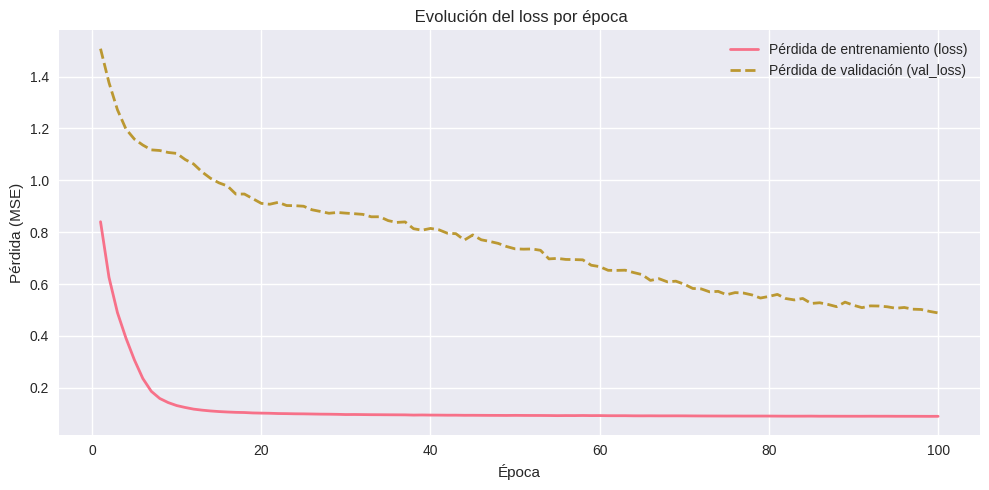

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop],
    verbose=1
)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Pérdida de entrenamiento (loss)', linewidth=2)
plt.plot(epochs, val_loss, label='Pérdida de validación (val_loss)', linestyle='--', linewidth=2)
plt.title(' Evolución del loss por época')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.compile(optimizer='adam', loss=MeanSquaredError())
model.save("Model/modelo_lstm.h5")

# Model_cargado = Load_Model ("Model/Model_lstm.h5")

### Results

In [40]:
# # Dictionary to store the results of all models
resultado_modelos = {}

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4373 - mae: 0.6371 - mape: 49.7577
[0.42174825072288513, 0.6023691296577454, 46.47174072265625]
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


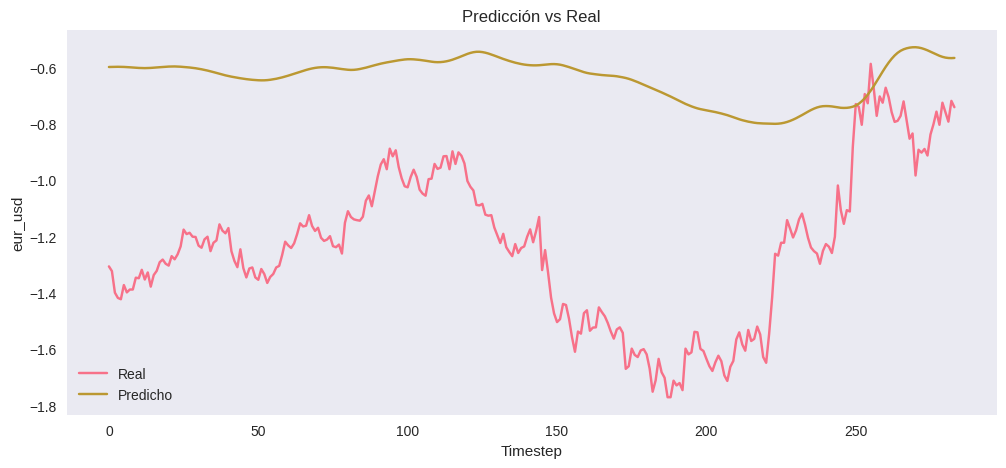

0.6023690751975782 0.4217482235441385 0.6494214529441867 -4.702855466856391


In [41]:

# Assessment
loss = model.evaluate(X_test_seq, y_test_seq)
print(loss)

# Predictions
y_pred_scaled = model.predict(X_test_seq)

# Invest scaling
y_pred = scaler.inverse_transform(y_pred_scaled)
y_real = scaler.inverse_transform(y_test_seq)

# Compare visually

plt.figure(figsize=(12, 5))
plt.plot(y_test_seq, label='Real')
plt.plot(y_pred_scaled, label='Predicho')
plt.legend()
plt.title("Predicción vs Real")
plt.xlabel("Timestep")
plt.ylabel("eur_usd")
plt.grid()
plt.show()

mae = mean_absolute_error(y_test_seq, y_pred_scaled)
mse = mean_squared_error(y_test_seq, y_pred_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq, y_pred_scaled)
print(mae , mse, rmse, r2)

resultado_modelos['LSTM'] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R²":r2
    }


## 7. Optimization of hyperparameters

### Optimizer

In [42]:
def set_seeds(seed=123):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Network architecture
def model_builder(hp):
    model = Sequential()

    model.add(LSTM(units = hp.Int('lstm_units', min_value=32, max_value=512, step=32),
                   activation='tanh',
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   return_sequences=hp.Boolean('stack_lstm')))

    model.add(Dropout(hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    if hp.get('stack_lstm'):
        model.add(LSTM(units = hp.Int('lstm_units_2', min_value=32, max_value=512, step=32),
                       activation='tanh',
                       return_sequences=False))
        model.add(Dropout(hp.Float('lstm_dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    dense_activation = hp.Choice('dense_activation', ['relu', 'tanh'])

    model.add(Dense(units=hp_dense_units, activation=dense_activation))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=AdamW(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

### Hyperparameter search

In [43]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='EURO/USD',
    overwrite=True,
    seed=123
)


# Set_seeds (999)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)

tuner.search(X_train_seq, y_train_seq, epochs=100, validation_data=(X_val_seq, y_val_seq), callbacks=[stop_early])

Trial 20 Complete [00h 00m 54s]
val_loss: 0.10085642337799072

Best val_loss So Far: 0.005302544683218002
Total elapsed time: 00h 15m 18s


### Hyperparameter results

In [44]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("El mejor número de neuronas LSTM es:", best_hps.get('lstm_units'))
print("El mejor número de neuronas para la capa Dense es:", best_hps.get('dense_units'))
print("La mejor función de activación para la capa Dense es:", best_hps.get('dense_activation'))
print("La mejor tasa de dropout de la capa Dense es:", best_hps.get('dense_dropout'))
print("La mejor tasa de dropout para la LSTM es:", best_hps.get('lstm_dropout'))
print("La mejor tasa de aprendizaje es:", best_hps.get('learning_rate'))

best_model = tuner.get_best_models(num_models=1)[0]

# Model evaluation
loss, mae = best_model.evaluate(X_test_seq, y_test_seq)
print("Loss:", loss)
print("MAE:", mae)

final_model = tuner.hypermodel.build(best_hps)

# Learning curve
# plot_training_history (final_model, '2.2. Learning curve for the LSTM.')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 416)       │       728,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 416)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512)            │     1,902,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,746,561 (10.48 MB)

 Trainable params: 2,746,561 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

El mejor número de neuronas LSTM es: 416
El mejor número de neuronas para la capa Dense es: 224
La mejor función de activación para la capa Dense es: relu
La mejor tasa de dropout de la capa Dense es: 0.4
La mejor tasa de dropout para la LSTM es: 0.0
La mejor tasa de aprendizaje es: 0.001
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0174 - mean_absolute_error: 0.0939
Loss: 0.03552739694714546
MAE: 0.14792010188102722


### Training of the final model

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.1659 - mean_absolute_error: 0.2896 - val_loss: 1.1612 - val_mean_absolute_error: 1.0560
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0361 - mean_absolute_error: 0.1454 - val_loss: 1.4309 - val_mean_absolute_error: 1.1603
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0216 - mean_absolute_error: 0.1150 - val_loss: 0.9641 - val_mean_absolute_error: 0.9475
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0220 - mean_absolute_error: 0.1113 - val_loss: 0.6340 - val_mean_absolute_error: 0.7562
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0211 - mean_absolute_error: 0.1092 - val_loss: 0.6009 - val_mean_absolute_error: 0.7432
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0175 - mean_absolute_error: 0.1019 - val_loss: 0.8372 - val_mean_absolute_error: 0.8724
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0177 - mean_absolute_error: 0.1007 - v

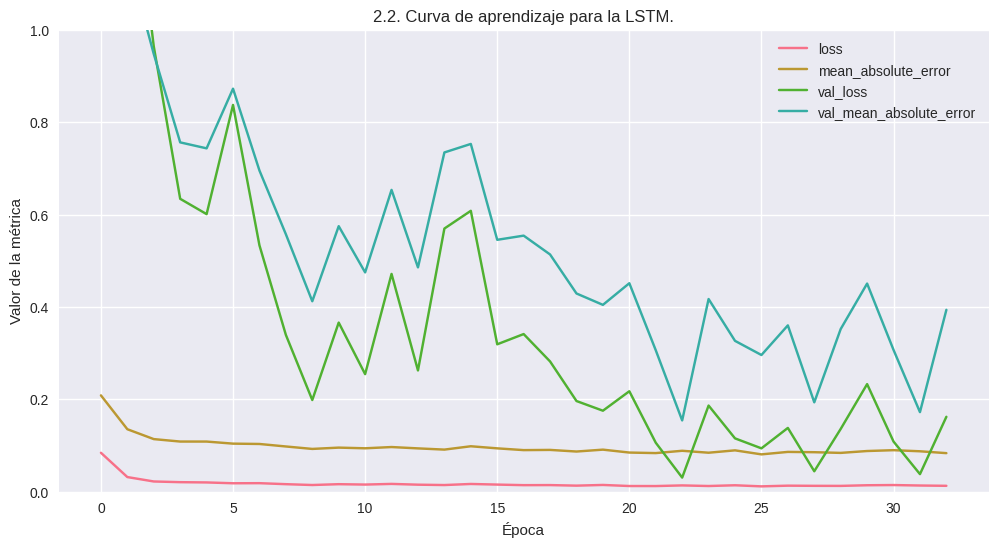

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MSE:  0.00018992069106650637
RMSE:  0.013781171614434906
MAE:  0.011870092326822417
R2_score:  0.7763706649713876


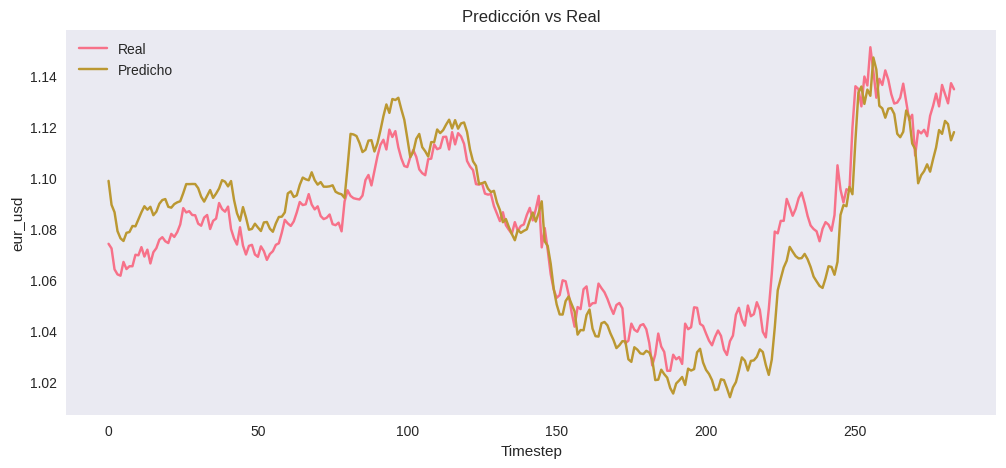

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = final_model.fit(X_train_seq, y_train_seq,
                        epochs=200,
                        validation_data = (X_val_seq, y_val_seq),
                        callbacks=[early_stopping])

loss, mae = final_model.evaluate(X_test_seq, y_test_seq)
print(f"Pérdida final en prueba: {loss}")
print(f"Precisión (MAE) final en prueba: {mae}")

# Learning curve
plot_training_history(history, '2.2. Curva de aprendizaje para la LSTM.')

# Performance
predictions_scaled = final_model.predict(X_test_seq)
y_pred = scaler.inverse_transform(predictions_scaled)
y_test_og = scaler.inverse_transform(y_test_seq.reshape(-1, 1))


print('MSE: ', mean_squared_error(y_test_og,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test_og,y_pred)))
print('MAE: ', mean_absolute_error(y_test_og,y_pred))
print('R2_score: ', r2_score(y_test_og,y_pred))

plt.figure(figsize=(12, 5))
plt.plot(y_test_og, label='Real')
plt.plot(y_pred, label='Predicho')
plt.legend()
plt.title("Predicción vs Real")
plt.xlabel("Timestep")
plt.ylabel("eur_usd")
plt.grid()
plt.show()

## 8. Best Trained Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 384)            │       623,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,019,077 (7.70 MB)

 Trainable params: 673,025 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,346,052 (5.13 MB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE:  0.00026357049752525724
RMSE:  0.016234854404190303
MAE:  0.011934965087998082
R2_score:  0.6896489015296734


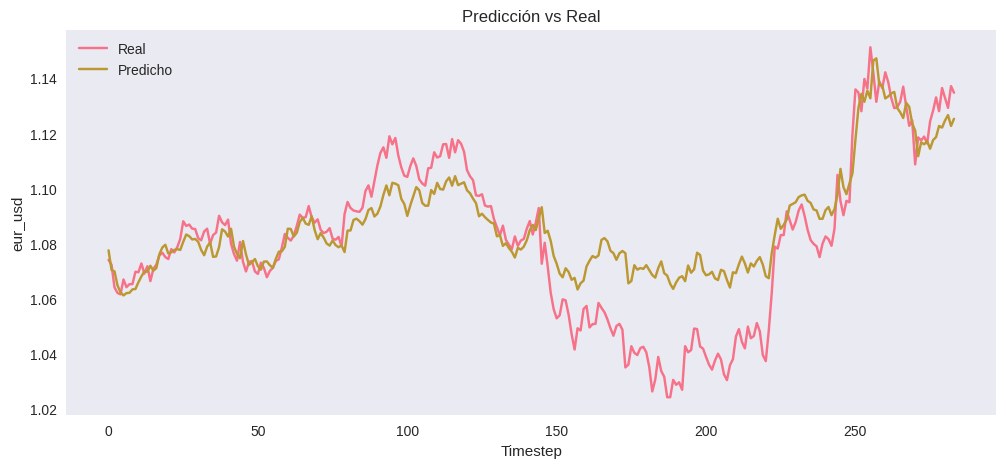

In [46]:
loaded_model = tf.keras.models.load_model('Model/LSTM_EU_USD.keras')
loaded_model.summary()

# Performance
predictions_scaled = loaded_model.predict(X_test_seq)
y_pred = scaler.inverse_transform(predictions_scaled)
y_test_og = scaler.inverse_transform(y_test_seq.reshape(-1, 1))


print('MSE: ', mean_squared_error(y_test_og,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test_og,y_pred)))
print('MAE: ', mean_absolute_error(y_test_og,y_pred))
print('R2_score: ', r2_score(y_test_og,y_pred))

plt.figure(figsize=(12, 5))
plt.plot(y_test_og, label='Real')
plt.plot(y_pred, label='Predicho')
plt.legend()
plt.title("Predicción vs Real")
plt.xlabel("Timestep")
plt.ylabel("eur_usd")
plt.grid()
plt.show()

# 3.2 RNN

Data are loaded

In [47]:
filepath = 'Dataset/df_completo.xlsx'
df_eurusd = pd.read_excel(filepath)

We visualize them

In [48]:
df_eurusd.head()

,fecha,oro,indice_dolar,petroleo_crudo_wti,petroleo_brent,vix_history,tasa_interes_bce,indice_euro,dow_jones,tasa_interes_fed,rendimiento_bonos_10_eeuu,rendimiento_bonos_2_eeuu,nasdaq,tasa_de_desempleo_usa,s_p_500,eur_usd,RSI,SMA,EMA,momentum,macd,signal,histogram
0,2010-01-20,1112.6,78.34,77.62,76.32,18.68,0.01,103.84,10603.15,0.003,3.653,0.882,2291.25,9.8,1138.0,1.4101,31.097561,1.440209,1.439088,-0.0310,-0.001547,0.000286,-0.001832
1,2010-01-21,1103.2,78.32,76.08,74.58,22.27,0.01,103.74,10389.88,0.003,3.595,0.833,2265.70,9.8,1116.5,1.4090,30.685921,1.437608,1.435076,-0.0278,-0.003796,-0.000530,-0.003265
2,2010-01-22,1089.7,78.28,74.54,72.83,27.31,0.01,103.99,10172.98,0.003,3.601,0.792,2205.29,9.8,1091.8,1.4137,34.396355,1.435769,1.432226,-0.0275,-0.005140,-0.001452,-0.003687
3,2010-01-25,1095.7,78.19,75.26,73.69,25.41,0.01,104.05,10196.86,0.003,3.630,0.816,2210.80,9.8,1096.8,1.4150,35.353535,1.434286,1.429929,-0.0168,-0.006031,-0.002368,-0.003663
4,2010-01-26,1098.3,78.43,74.71,73.29,24.55,0.01,103.62,10194.29,0.003,3.621,0.811,2203.73,9.8,1092.2,1.4073,32.541322,1.431871,1.426912,-0.0339,-0.007274,-0.003349,-0.003925


Data preprocessing is performed

In [49]:
# Convert date format
df_eurusd['fecha'] = pd.to_datetime(df_eurusd['fecha'])

# Indexar the date
df_eurusd.set_index('fecha', inplace=True)

# Divide dependent and independent variables
X = df_eurusd.drop(['eur_usd'], axis=1)
y = df_eurusd['eur_usd']

# Calculate the number of samples
n = len(X)
train_end = int(n*0.8)
val_end = int(n*0.9)

# Divide the data into training, validation and test
df_train_X = X.iloc[:train_end]
df_val_X = X.iloc[train_end:val_end]
df_test_X = X.iloc[val_end:]

df_train_Y = y.iloc[:train_end]
df_val_Y = y.iloc[train_end:val_end]
df_test_Y = y.iloc[val_end:]

The data is prepared

In [50]:
from datetime import datetime

# Alternative method
def create_dataset(X, y, time_steps):

  X_seq, Y_seq = [], []
  for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])
    Y_seq.append(y[i+time_steps])

  return np.array(X_seq), np.array(Y_seq)

# Taking into account that the data is daily, a time_steps <= n_train // 10
# Define the Time_Steps
time_steps = 100

# Climb the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
df_train_X_scaled = scaler_X.fit_transform(df_train_X)
df_val_X_scaled = scaler_X.transform(df_val_X)
df_test_X_scaled = scaler_X.transform(df_test_X)

# Climb the data
scaler_Y = MinMaxScaler(feature_range=(0, 1))
df_train_Y_scaled = scaler_Y.fit_transform(df_train_Y.values.reshape(-1, 1))
df_val_Y_scaled = scaler_Y.transform(df_val_Y.values.reshape(-1, 1))
df_test_Y_scaled = scaler_Y.transform(df_test_Y.values.reshape(-1, 1))

# Flatten the array
df_train_Y_scaled = df_train_Y_scaled.ravel()
df_val_Y_scaled = df_val_Y_scaled.ravel()
df_test_Y_scaled = df_test_Y_scaled.ravel()

# Build training and test sets
X_train_se, Y_train_se = create_dataset(df_train_X_scaled, df_train_Y_scaled, time_steps)
X_val_se, Y_val_se = create_dataset(df_val_X_scaled, df_val_Y_scaled, time_steps)
X_test_se, Y_test_se = create_dataset(df_test_X_scaled, df_test_Y_scaled, time_steps)

We review the amount of data for Train, Test and Val

In [51]:
print(df_train_X_scaled.shape)
print(df_train_Y_scaled.shape)
print(df_val_X_scaled.shape)
print(df_val_Y_scaled.shape)
print(df_test_X_scaled.shape)
print(df_test_Y_scaled.shape)

(3067, 21)
(3067,)
(383, 21)
(383,)
(384, 21)
(384,)


We generate model architecture

In [52]:
model = Sequential()
model.add(Input(shape=(X_train_se.shape[1], X_train_se.shape[2])))
model.add(SimpleRNN(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=100, activation='tanh', return_sequences=True))
model.add(SimpleRNN(1))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100, 100)       │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 100)       │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100, 100)       │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 1)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,502 (205.09 KB)

 Trainable params: 52,502 (205.09 KB)

 Non-trainable params: 0 (0.00 B)

We train the model

In [53]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error')

# Implement Early Stopping
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True)

# Train the model
history = model.fit(X_train_se,
                    Y_train_se,
                    epochs=50,
                    validation_data=(X_val_se, Y_val_se),
                    callbacks=[es],
                    batch_size=32,
                    verbose=1)

Epoch 1/50


I0000 00:00:1753216428.917566  125520 service.cc:152] XLA service 0x78be1800cd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753216428.917608  125520 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-07-22 15:33:49.085887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3897

I0000 00:00:1753216433.850780  125520 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.3137 - val_loss: 0.2663
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0822 - val_loss: 0.0707
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0307 - val_loss: 0.0404
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0074 - val_loss: 0.0168
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0033 - val_loss: 0.0206
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0022 - val_

We graph the Training Loss and Validation Loss function

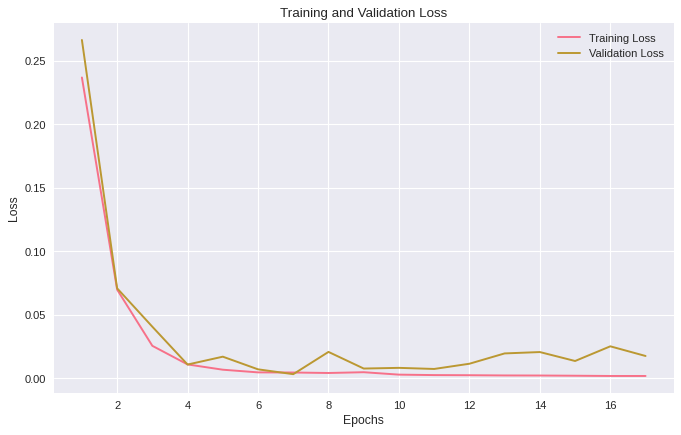

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Model predictions

In [55]:
train_predict = model.predict(X_train_se)
val_predict = model.predict(X_val_se)
test_predict = model.predict(X_test_se)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


Performance metric

In [56]:
print(f'MSE: {metrics.mean_squared_error(Y_test_se, test_predict)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(Y_test_se, test_predict))}')
print(f'MAE: {metrics.mean_absolute_error(Y_test_se, test_predict)}')
print(f'R2_score: {metrics.r2_score(Y_test_se, test_predict)}')

MSE: 0.002908896952037587
RMSE: 0.05393419093708171
MAE: 0.03970781756716941
R2_score: 0.3244673046192754


We show the results

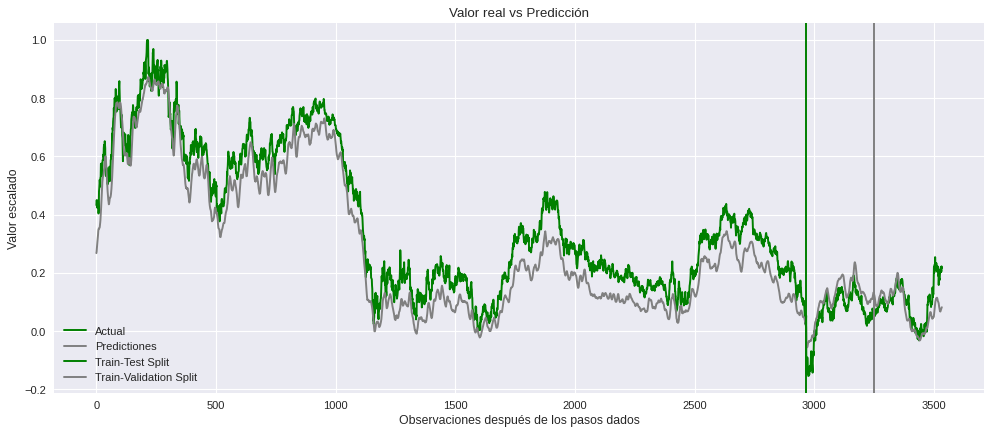

In [57]:
# Plot the result
def plot_result(Y_train_se, Y_val_se, Y_test_se, train_predict, val_predict, test_predict):
    actual = np.concatenate([Y_train_se, Y_val_se, Y_test_se])
    predictions = np.concatenate([train_predict, val_predict, test_predict])
    rows = len(actual)
    split1 = len(Y_train_se)
    split2 = len(Y_train_se) + len(Y_val_se)

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual, color='green')
    plt.plot(range(rows), predictions, color='gray')

    plt.axvline(x=split1, color='green', label='Train-Test Split')
    plt.axvline(x=split2, color='gray', label='Train-Validation Split')
    plt.legend(['Actual', 'Predictiones', 'Train-Test Split', 'Train-Validation Split'])

    plt.xlabel('Observaciones después de los pasos dados')
    plt.ylabel('Valor escalado')
    plt.title('Valor real vs Predicción')
    plt.grid(True)
    plt.show()
plot_result(Y_train_se, Y_val_se, Y_test_se, train_predict, val_predict, test_predict)

Extraction and reduction of characteristics

In [58]:
pca = PCA(n_components=0.95)
X_train_se_pca = pca.fit_transform(df_train_X_scaled)
X_val_se_pca = pca.transform(df_val_X_scaled)
X_test_se_pca = pca.transform(df_test_X_scaled)

print(f'Cantidad de características iniciales: {df_train_X_scaled.shape[1]}')
print(f'Cantidad de características finales: {X_train_se_pca.shape[1]}')

Cantidad de características iniciales: 21
Cantidad de características finales: 7


Build training and test sets

In [59]:
X_train_pca, Y_train_se = create_dataset(X_train_se_pca, df_train_Y_scaled, time_steps)
X_val_pca, Y_val_se = create_dataset(X_val_se_pca, df_val_Y_scaled, time_steps)
X_test_pca, Y_test_se = create_dataset(X_test_se_pca, df_test_Y_scaled, time_steps)

Model architecture

In [60]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(X_train_pca.shape[1], X_train_pca.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(units=32, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(units=32, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(1))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 32)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 1)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,474 (21.38 KB)

 Trainable params: 5,474 (21.38 KB)

 Non-trainable params: 0 (0.00 B)

The model is compiled, an Early Stopping is implemented and trained

In [61]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   restore_best_weights=True)

history = model.fit(X_train_pca,
                    Y_train_se,
                    epochs=50,
                    validation_data=(X_val_pca, Y_val_se),
                    # validation_split = 0.1,
                    callbacks=[es],
                    batch_size=32,
                    verbose=1)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - loss: 0.3181 - val_loss: 0.4182
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1359 - val_loss: 0.5213
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0985 - val_loss: 0.3784
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0778 - val_loss: 0.2301
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0564 - val_loss: 0.2277
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0435 - val_loss: 0.2353
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0319 - val_loss: 0.2662
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0246 - val_loss: 0.2365
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0209 - val_loss: 0.2688
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0157 - val_loss: 0.2545
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0141 - val_loss: 0.2196
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0

We graph Training Loss and Validation Loss

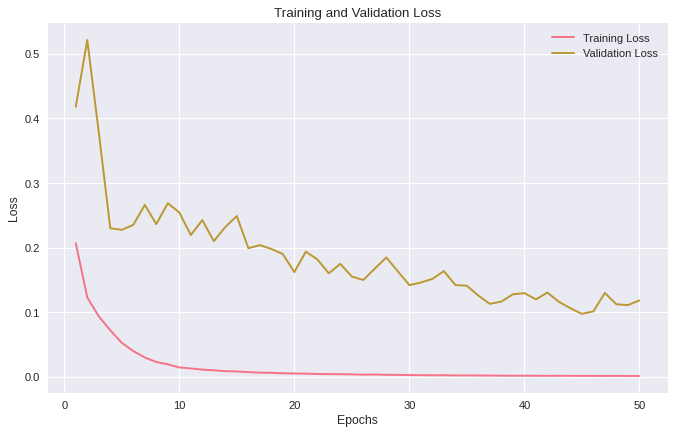

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

We perform predictions

In [63]:
train_predict_pca = model.predict(X_train_pca)
val_predict_pca = model.predict(X_val_pca)
test_predict_pca = model.predict(X_test_pca)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


We visualize the metric

In [64]:
print(f'MSE: {metrics.mean_squared_error(Y_test_se, test_predict_pca)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(Y_test_se, test_predict_pca))}')
print(f'MAE: {metrics.mean_absolute_error(Y_test_se, test_predict_pca)}')
print(f'R2_score: {metrics.r2_score(Y_test_se, test_predict_pca)}')

MSE: 0.07380629945309433
RMSE: 0.2716731482003592
MAE: 0.26699930777478126
R2_score: -16.140025661858328


We graph the final result

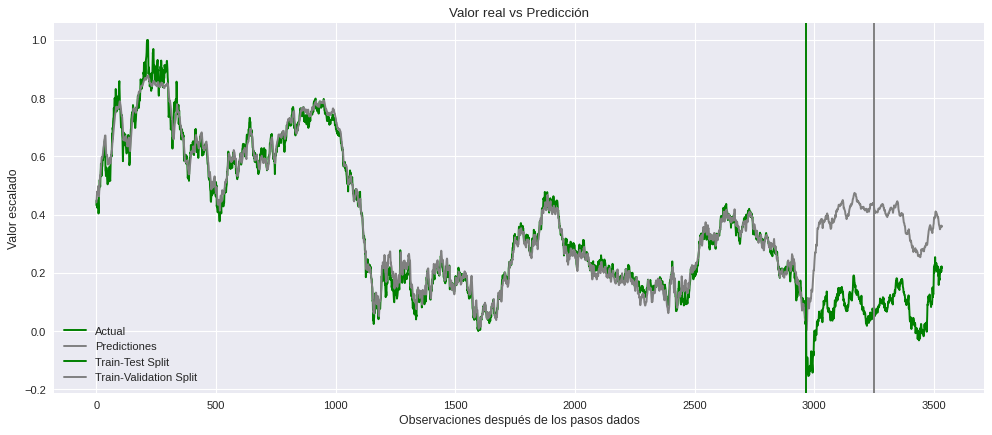

In [65]:
plot_result(Y_train_se, Y_val_se, Y_test_se, train_predict_pca, val_predict_pca, test_predict_pca)

# 3.3 Random Forest Valsor / XGBOOST

The files are loaded and the first 5 data are shown

In [66]:
# Excel Archive Route on Google Drive
ruta_excel = "Dataset/df_completo.xlsx"

# Read Excel
df_completo = pd.read_excel(ruta_excel)

# Show the first rows to confirm
df_completo.head()

,fecha,oro,indice_dolar,petroleo_crudo_wti,petroleo_brent,vix_history,tasa_interes_bce,indice_euro,dow_jones,tasa_interes_fed,rendimiento_bonos_10_eeuu,rendimiento_bonos_2_eeuu,nasdaq,tasa_de_desempleo_usa,s_p_500,eur_usd,RSI,SMA,EMA,momentum,macd,signal,histogram
0,2010-01-20,1112.6,78.34,77.62,76.32,18.68,0.01,103.84,10603.15,0.003,3.653,0.882,2291.25,9.8,1138.0,1.4101,31.097561,1.440209,1.439088,-0.0310,-0.001547,0.000286,-0.001832
1,2010-01-21,1103.2,78.32,76.08,74.58,22.27,0.01,103.74,10389.88,0.003,3.595,0.833,2265.70,9.8,1116.5,1.4090,30.685921,1.437608,1.435076,-0.0278,-0.003796,-0.000530,-0.003265
2,2010-01-22,1089.7,78.28,74.54,72.83,27.31,0.01,103.99,10172.98,0.003,3.601,0.792,2205.29,9.8,1091.8,1.4137,34.396355,1.435769,1.432226,-0.0275,-0.005140,-0.001452,-0.003687
3,2010-01-25,1095.7,78.19,75.26,73.69,25.41,0.01,104.05,10196.86,0.003,3.630,0.816,2210.80,9.8,1096.8,1.4150,35.353535,1.434286,1.429929,-0.0168,-0.006031,-0.002368,-0.003663
4,2010-01-26,1098.3,78.43,74.71,73.29,24.55,0.01,103.62,10194.29,0.003,3.621,0.811,2203.73,9.8,1092.2,1.4073,32.541322,1.431871,1.426912,-0.0339,-0.007274,-0.003349,-0.003925


In [69]:
# DF is already loaded and has the correct structure
df = df_completo.copy()


# Establish the temporal index
df = df.sort_values("fecha").set_index("fecha")

# Verify null values
print(df.isnull().sum())

oro                          0
indice_dolar                 0
petroleo_crudo_wti           0
petroleo_brent               0
vix_history                  0
tasa_interes_bce             0
indice_euro                  0
dow_jones                    0
tasa_interes_fed             0
rendimiento_bonos_10_eeuu    0
rendimiento_bonos_2_eeuu     0
nasdaq                       0
tasa_de_desempleo_usa        0
s_p_500                      0
eur_usd                      0
RSI                          0
SMA                          0
EMA                          0
momentum                     0
macd                         0
signal                       0
histogram                    0
dtype: int64


We get the values of Train, Val and Test, we also build the pipeline and the hyperparameter grid

In [70]:
# Independent variables (features) and dependent (target)
X = df.drop(columns=["eur_usd"])
y = df["eur_usd"]

# Define numerical columns to climb and impute if necessary
numerical_features = X.select_dtypes(include=['float64', 'int']).columns.tolist()

# === Temporary Data Division === (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.90)

# Divisions
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Combine Train + Val for Grid Search with Cross-Validation
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Pipeline
pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# Hyperparameters
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 7, 10, None],
    "model__min_samples_split": [2, 5]
}

We perform cross validation with temporary series within Train + Val

In [71]:
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_trainval, y_trainval)


print("🔧 Mejor modelo:")
print(grid_search.best_estimator_)

🔧 Mejor modelo:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_estimators=300, random_state=42))])


We perform predictions

In [72]:
# Predictions
y_pred = grid_search.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 MAE: {mae:.6f}")
print(f"📉 MSE: {mse:.6f}")
print(f"📉 RMSE: {rmse:.6f}")
print(f"📊 R²: {r2:.6f}")


resultado_modelos['RandomForest'] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R²":r2
    }


📈 MAE: 0.003857
📉 MSE: 0.000030
📉 RMSE: 0.005494
📊 R²: 0.953574


We graph the results

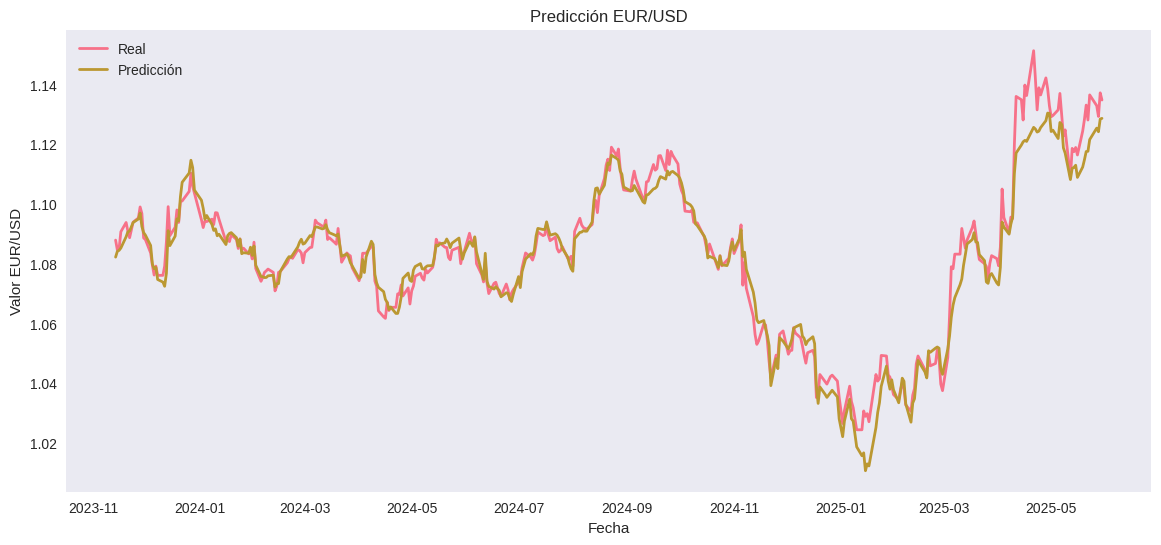

In [73]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicción', linewidth=2)
plt.title('Predicción EUR/USD')
plt.xlabel('Fecha')
plt.ylabel('Valor EUR/USD')
plt.legend()
plt.grid()
plt.show()

Using Selectkbest

🔧 Mejor modelo:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x78bf30f60c10>)),
                ('model',
                 RandomForestRegressor(n_estimators=300, random_state=42))])
📈 MAE: 0.007893
📉 MSE: 0.000100
📉 RMSE: 0.009998
📊 R²: 0.846270


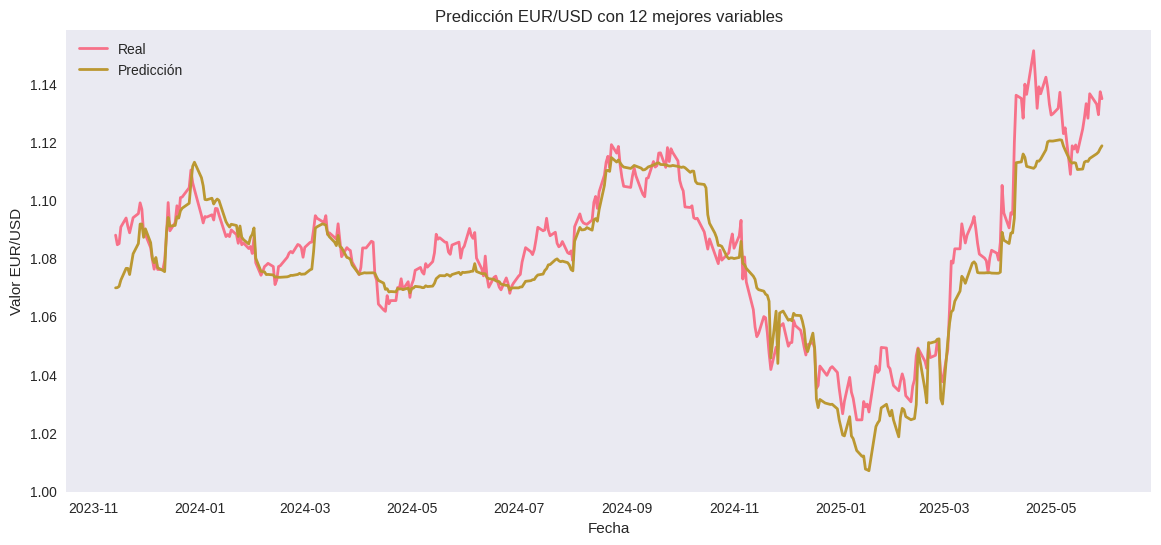


📊 Top 15 variables seleccionadas por F-score:
                    Variable        F_Score        P_Value
0                        EMA  341826.117426   0.000000e+00
1                        SMA  247189.559131   0.000000e+00
2               indice_dolar   77908.617975   0.000000e+00
3                  dow_jones    2833.916930   0.000000e+00
4      tasa_de_desempleo_usa    2780.341906   0.000000e+00
5                    s_p_500    2683.534210   0.000000e+00
6             petroleo_brent    2067.849854   0.000000e+00
7                     nasdaq    2025.915013   0.000000e+00
8         petroleo_crudo_wti    1816.687158  3.044927e-319
9   rendimiento_bonos_2_eeuu    1579.404059  1.080266e-284
10          tasa_interes_fed    1233.636919  2.646336e-231
11                       oro      69.398071   1.147010e-16
12                    signal      63.527369   2.130875e-15
13                      macd      55.993182   9.179307e-14
14                       RSI      31.633992   2.009665e-08


In [75]:
# === Data ===
df = df_completo.copy().sort_values("fecha").set_index("fecha")
X = df.drop(columns=["eur_usd"])
y = df["eur_usd"]

# === Division Train / Val / Test === (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.90)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Combine Train + Val for Cross Validation
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# === Pipeline with selector k = 12 ===
pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_regression, k=12)),
    ("model", RandomForestRegressor(random_state=42))
])

# === Hyperparameters ===
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 7, 10, None],
    "model__min_samples_split": [2, 5]
}

# === Cross validation ===
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_trainval, y_trainval)

# === Evaluation in test ===
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("🔧 Mejor modelo:")
print(grid_search.best_estimator_)
print(f"📈 MAE: {mae:.6f}")
print(f"📉 MSE: {mse:.6f}")
print(f"📉 RMSE: {rmse:.6f}")
print(f"📊 R²: {r2:.6f}")

# === Graph ===
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicción', linewidth=2)
plt.title('Predicción EUR/USD con 12 mejores variables')
plt.xlabel('Fecha')
plt.ylabel('Valor EUR/USD')
plt.legend()
plt.grid()
plt.show()

# === Variable ranking ===
# Adjust selector outside the Pipeline on full Trainval
selector = SelectKBest(score_func=f_regression, k=15)
selector.fit(X_trainval, y_trainval)

selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
f_scores = selector.scores_[selected_mask]
p_values = selector.pvalues_[selected_mask]

ranking_df = pd.DataFrame({
    "Variable": selected_features,
    "F_Score": f_scores,
    "P_Value": p_values
}).sort_values(by="F_Score", ascending=False)

print("\n📊 Top 15 variables seleccionadas por F-score:")
print(ranking_df.reset_index(drop=True))


Using xgboost

Data Preparation

In [76]:
df = df_completo.copy()
# Prepare Dataframe

df = df.sort_values("fecha").set_index("fecha")

# Independent and dependent variables
X = df.drop(columns=["eur_usd"])
y = df["eur_usd"]

Separate training, test and preparation of hyperparameters

In [77]:
# === Division Train / Val / Test === (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Combine Train + Val for Cross Validation
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Pipeline with XGBOOST
# === Pipeline with xgboost ===
pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Hyperparameters to search
# === Hyperparameters ===
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 5, 7],
    # "Model__learning_Rate": [0.01, 0.1, 0.3],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

# Validation with temporary series
# === Temporary cross validation ===
tscv = TimeSeriesSplit(n_splits=5)


Train with Gridsearchcv

In [78]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)


# 9️⃣ see better model
print("🔧 Mejor modelo XGBoost:")
print(grid_search.best_estimator_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
🔧 Mejor modelo XGBoost:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=

Predictions in Test and Metric

In [79]:
y_pred = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 MAE: {mae:.6f}")
print(f"📉 MSE: {mse:.6f}")
print(f"📉 RMSE: {rmse:.6f}")
print(f"📊 R²: {r2:.6f}")


resultado_modelos['XGBoost'] = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R²":r2
    }


📈 MAE: 0.004410
📉 MSE: 0.000042
📉 RMSE: 0.006471
📊 R²: 0.935600


In [80]:
# Models results
print(resultado_modelos)

{'LSTM': {'MAE': 0.6023690751975782, 'MSE': 0.4217482235441385, 'RMSE': np.float64(0.6494214529441867), 'R²': -4.702855466856391}, 'RandomForest': {'MAE': 0.003856570312500123, 'MSE': 3.0186108515336418e-05, 'RMSE': np.float64(0.005494188613010698), 'R²': 0.9535739200203741}, 'XGBoost': {'MAE': 0.004409761056303979, 'MSE': 4.1872412406201855e-05, 'RMSE': np.float64(0.006470889614744008), 'R²': 0.9356004446110517}}


RESULTS GRAPH

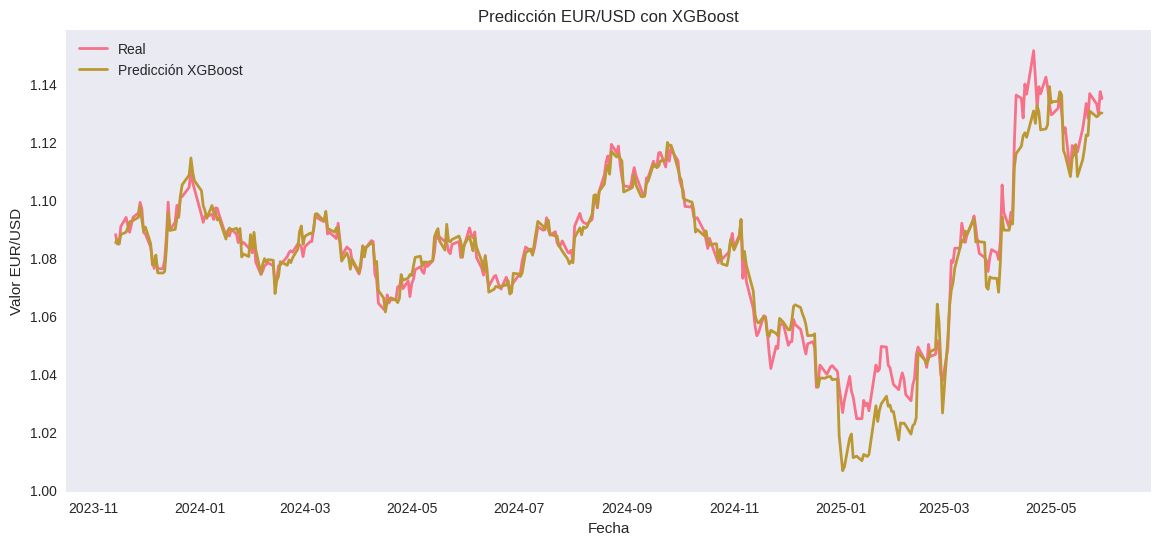

In [81]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicción XGBoost', linewidth=2)
plt.title('Predicción EUR/USD con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Valor EUR/USD')
plt.legend()
plt.grid()
plt.show()
